In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import colors
import matplotlib
import matplotlib.ticker as mtick
from tqdm.notebook import tqdm
import pingouin as pg
from adjustText import adjust_text

%matplotlib inline 

In [2]:
seed = 1126

### Data Preprocessing

In [3]:
## Define Strikezone
strike_zone = pd.DataFrame({
  'PlateLocSide': [-0.708, -0.708, 0.708, 0.708, -0.708],
  'PlateLocHeight': [1.5, 3.5, 3.5, 1.5, 1.5]
})

## Add strike zone to Plot
def draw_line(axis, alpha_spot = 1, catcher_p = True):
    axis.plot(strike_zone['PlateLocSide'], strike_zone['PlateLocHeight'], color = 'black', linewidth = 1.3, zorder = 3,alpha = alpha_spot,)

In [4]:
colour_palette = ['#FFB000','#648FFF','#785EF0',
                  '#DC267F','#FE6100','#3D1EB2','#894D80','#16AA02','#B5592B','#A3C1ED']

In [5]:
data_2021 = pd.read_csv('./data/2021_data.csv')
data_2022 = pd.read_csv('./data/2022_data.csv')
data_2023 = pd.read_csv('./data/2023_data.csv')
data_2024 = pd.read_csv('./data/2024_data.csv')

In [6]:
## Define a dictionary to group outcomes together
des_dict = {'ball':'ball',
'hit_into_play':'hit_into_play',
'called_strike':'called_strike',
'foul':'foul',
'swinging_strike':'swinging_strike',
'blocked_ball':'ball',
'swinging_strike_blocked':'swinging_strike',
'foul_tip':'swinging_strike',
'foul_bunt':'foul',
'hit_by_pitch':'hit_by_pitch',
'pitchout':'ball',
'missed_bunt':'swinging_strike',
'bunt_foul_tip':'swinging_strike',
'foul_pitchout':'foul',}

## Define a dictionary to group events together
ev_dict = {
 'single':'single',
 'walk':'walk',
 np.nan:np.nan,
 'strikeout':'strikeout',
 'field_out':'field_out',
 'force_out':'field_out',
 'double':'double',
 'hit_by_pitch':'hit_by_pitch',
 'home_run':'home_run',
 'grounded_into_double_play':'field_out',
 'fielders_choice_out':'field_out',
 'fielders_choice':'field_out',
 'field_error':'field_out',
 'double_play':'field_out',
 'sac_fly':'field_out',
 'strikeout_double_play':np.nan,
 'triple':'triple',
 'sac_bunt':'field_out',
 'catcher_interf':np.nan,
 'sac_fly_double_play':'field_out',
 'triple_play':'field_out',
 'other_out':'field_out',
 'wild_pitch':'wild_pitch',
 'sac_bunt_double_play':'field_out',
 'truncated_pa': np.nan}

In [7]:
all_train_data = pd.concat([data_2021, data_2022, data_2023]).reset_index(drop = True)

In [8]:
swing_in = ['foul_bunt','foul','hit_into_play','swinging_strike', 'foul_tip', 'swinging_strike_blocked','missed_bunt','bunt_foul_tip', 'foul_pitchout']

In [9]:
## Define a function which applies relevant transformations
def df_clean(df):
    # Create a new column with the grouped decisions
    df['des_new'] = df.description.map(des_dict)
    # Create a new column with the grouped events
    df['ev_new'] = df.loc[df['des_new'] == 'hit_into_play', 'events'].map(ev_dict)
    df.loc[df['des_new'] == 'hit_into_play', 'des_new'] = df.loc[df['des_new'] == 'hit_into_play', 'ev_new']
    df = df.dropna(subset = ['des_new'])
    # Filter rare cases
    df = df[(df.strikes <= 2) & (df.balls <= 3)]
    df.loc[:, 'count'] = df.loc[:, 'balls'].astype(str) + '-' + df.loc[:, 'strikes'].astype(str)
    df['count'] = df['count'].astype("category")
    # Create a dataset with average run expectancy 
    # given outcome and count
    des_values = df.groupby(['des_new', 'count'], observed = False)['delta_run_exp'].mean()
    # Merge the average run expectancies to the dataset
    df = df.merge(des_values, left_on = ['des_new', 'count'], right_on = ['des_new', 'count'], suffixes = ['', '_mean'])
    # Add a binary columns for swings
    conditions_swings = [(df['description'].isin(swing_in))]
    choices_swings = [True]
    df['swing'] = np.select(conditions_swings, choices_swings, default = 0)
    
    return df

## Transform the Datasets
processed_train_data = df_clean(df = all_train_data).dropna(subset = ['pitch_type'])
processed_test_data = df_clean(df = data_2024).dropna(subset = ['pitch_type'])

In [10]:
print(processed_train_data.shape)
print(processed_test_data.shape) 

(2135293, 123)
(708533, 123)


### EDA

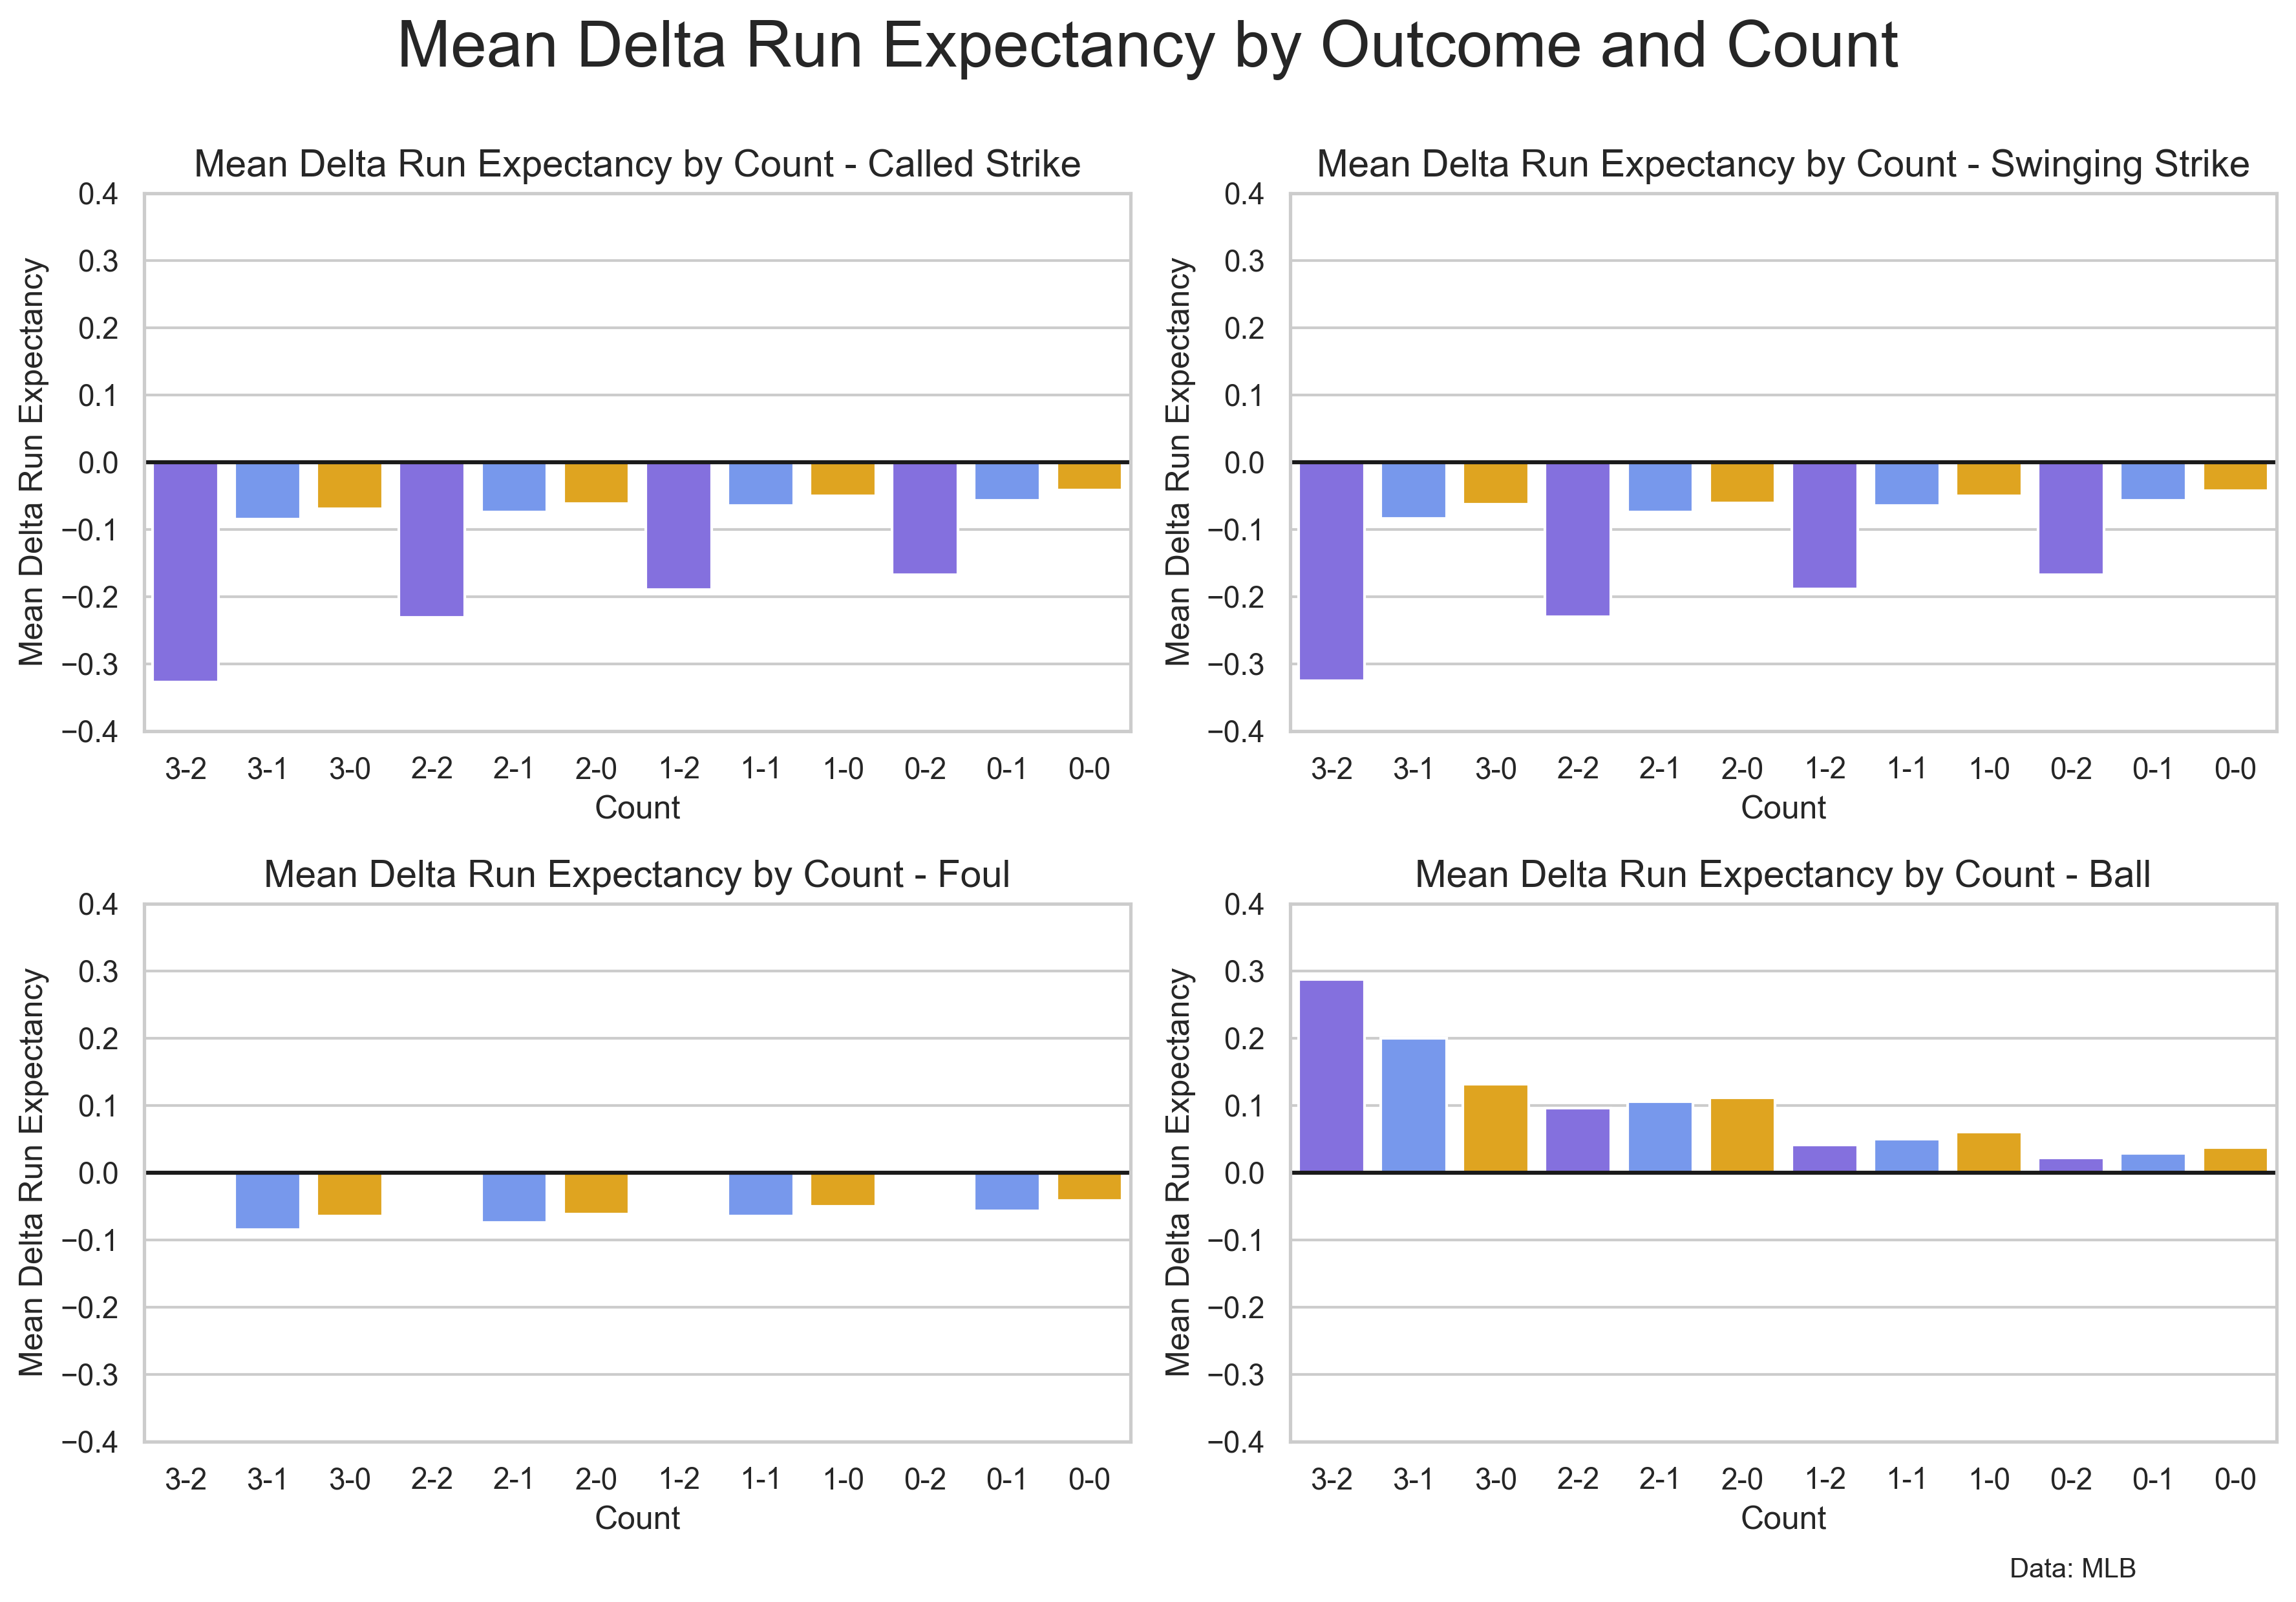

In [11]:
## Create Dataframe to plot Run Expectancies for Hits into Play
outcomes_delta = ['swinging_strike', 'called_strike', 'foul', 'ball']
outcomes_df = processed_train_data.groupby(['des_new', 'strikes', 'balls'])['delta_run_exp_mean'].mean().sort_values().reset_index()
outcomes_df = outcomes_df[outcomes_df.des_new.isin(outcomes_delta)]
outcomes_df = outcomes_df[(outcomes_df.strikes <= 2) & (outcomes_df.balls <= 3)]
outcomes_df['count'] = outcomes_df.balls.astype(str) + '-' + outcomes_df.strikes.astype(str)
outcomes_df = outcomes_df.sort_values(['balls', 'strikes'], ascending = False)
 

outcome_titles = {'swinging_strike':'Swinging Strike',
'called_strike':'Called Strike',
'foul':'Foul',
'hit_into_play':'Hit Into Play',
'ball':'Ball'}


sns.set_theme(style = "whitegrid")

fig, ax = plt.subplots(2, 2, figsize = (12, 8), dpi = 300)

axs = ax.flatten()
for outx in range(0, outcomes_df.des_new.nunique()):
    
    sns.barplot(data = outcomes_df[outcomes_df.des_new == outcomes_df.des_new.unique()[outx]],
                y = 'delta_run_exp_mean', x = 'count', hue = 'count', palette = colour_palette[2::-1] * 4, ax = axs[outx])

    axs[outx].set_ylim(-0.4, 0.4)
    axs[outx].hlines(y = 0, xmin = -0.5, xmax = 11.5, color = 'k')
    axs[outx].set_xlim(-0.5, 11.5)

    axs[outx].set_xlabel('Count')
    axs[outx].set_ylabel('Mean Delta Run Expectancy')
    axs[outx].set_title(f'Mean Delta Run Expectancy by Count - {outcome_titles[outcomes_df.des_new.unique()[outx]]}', fontsize = 14)

fig.suptitle(x = 0.5, y = 0.98, t = "Mean Delta Run Expectancy by Outcome and Count", ha = 'center', va = 'center', fontsize = 24)
fig.text(0.925, 0.00, "Data: MLB", ha = 'right', va = 'center', fontsize = 10)
fig.set_facecolor('white')
fig.tight_layout()

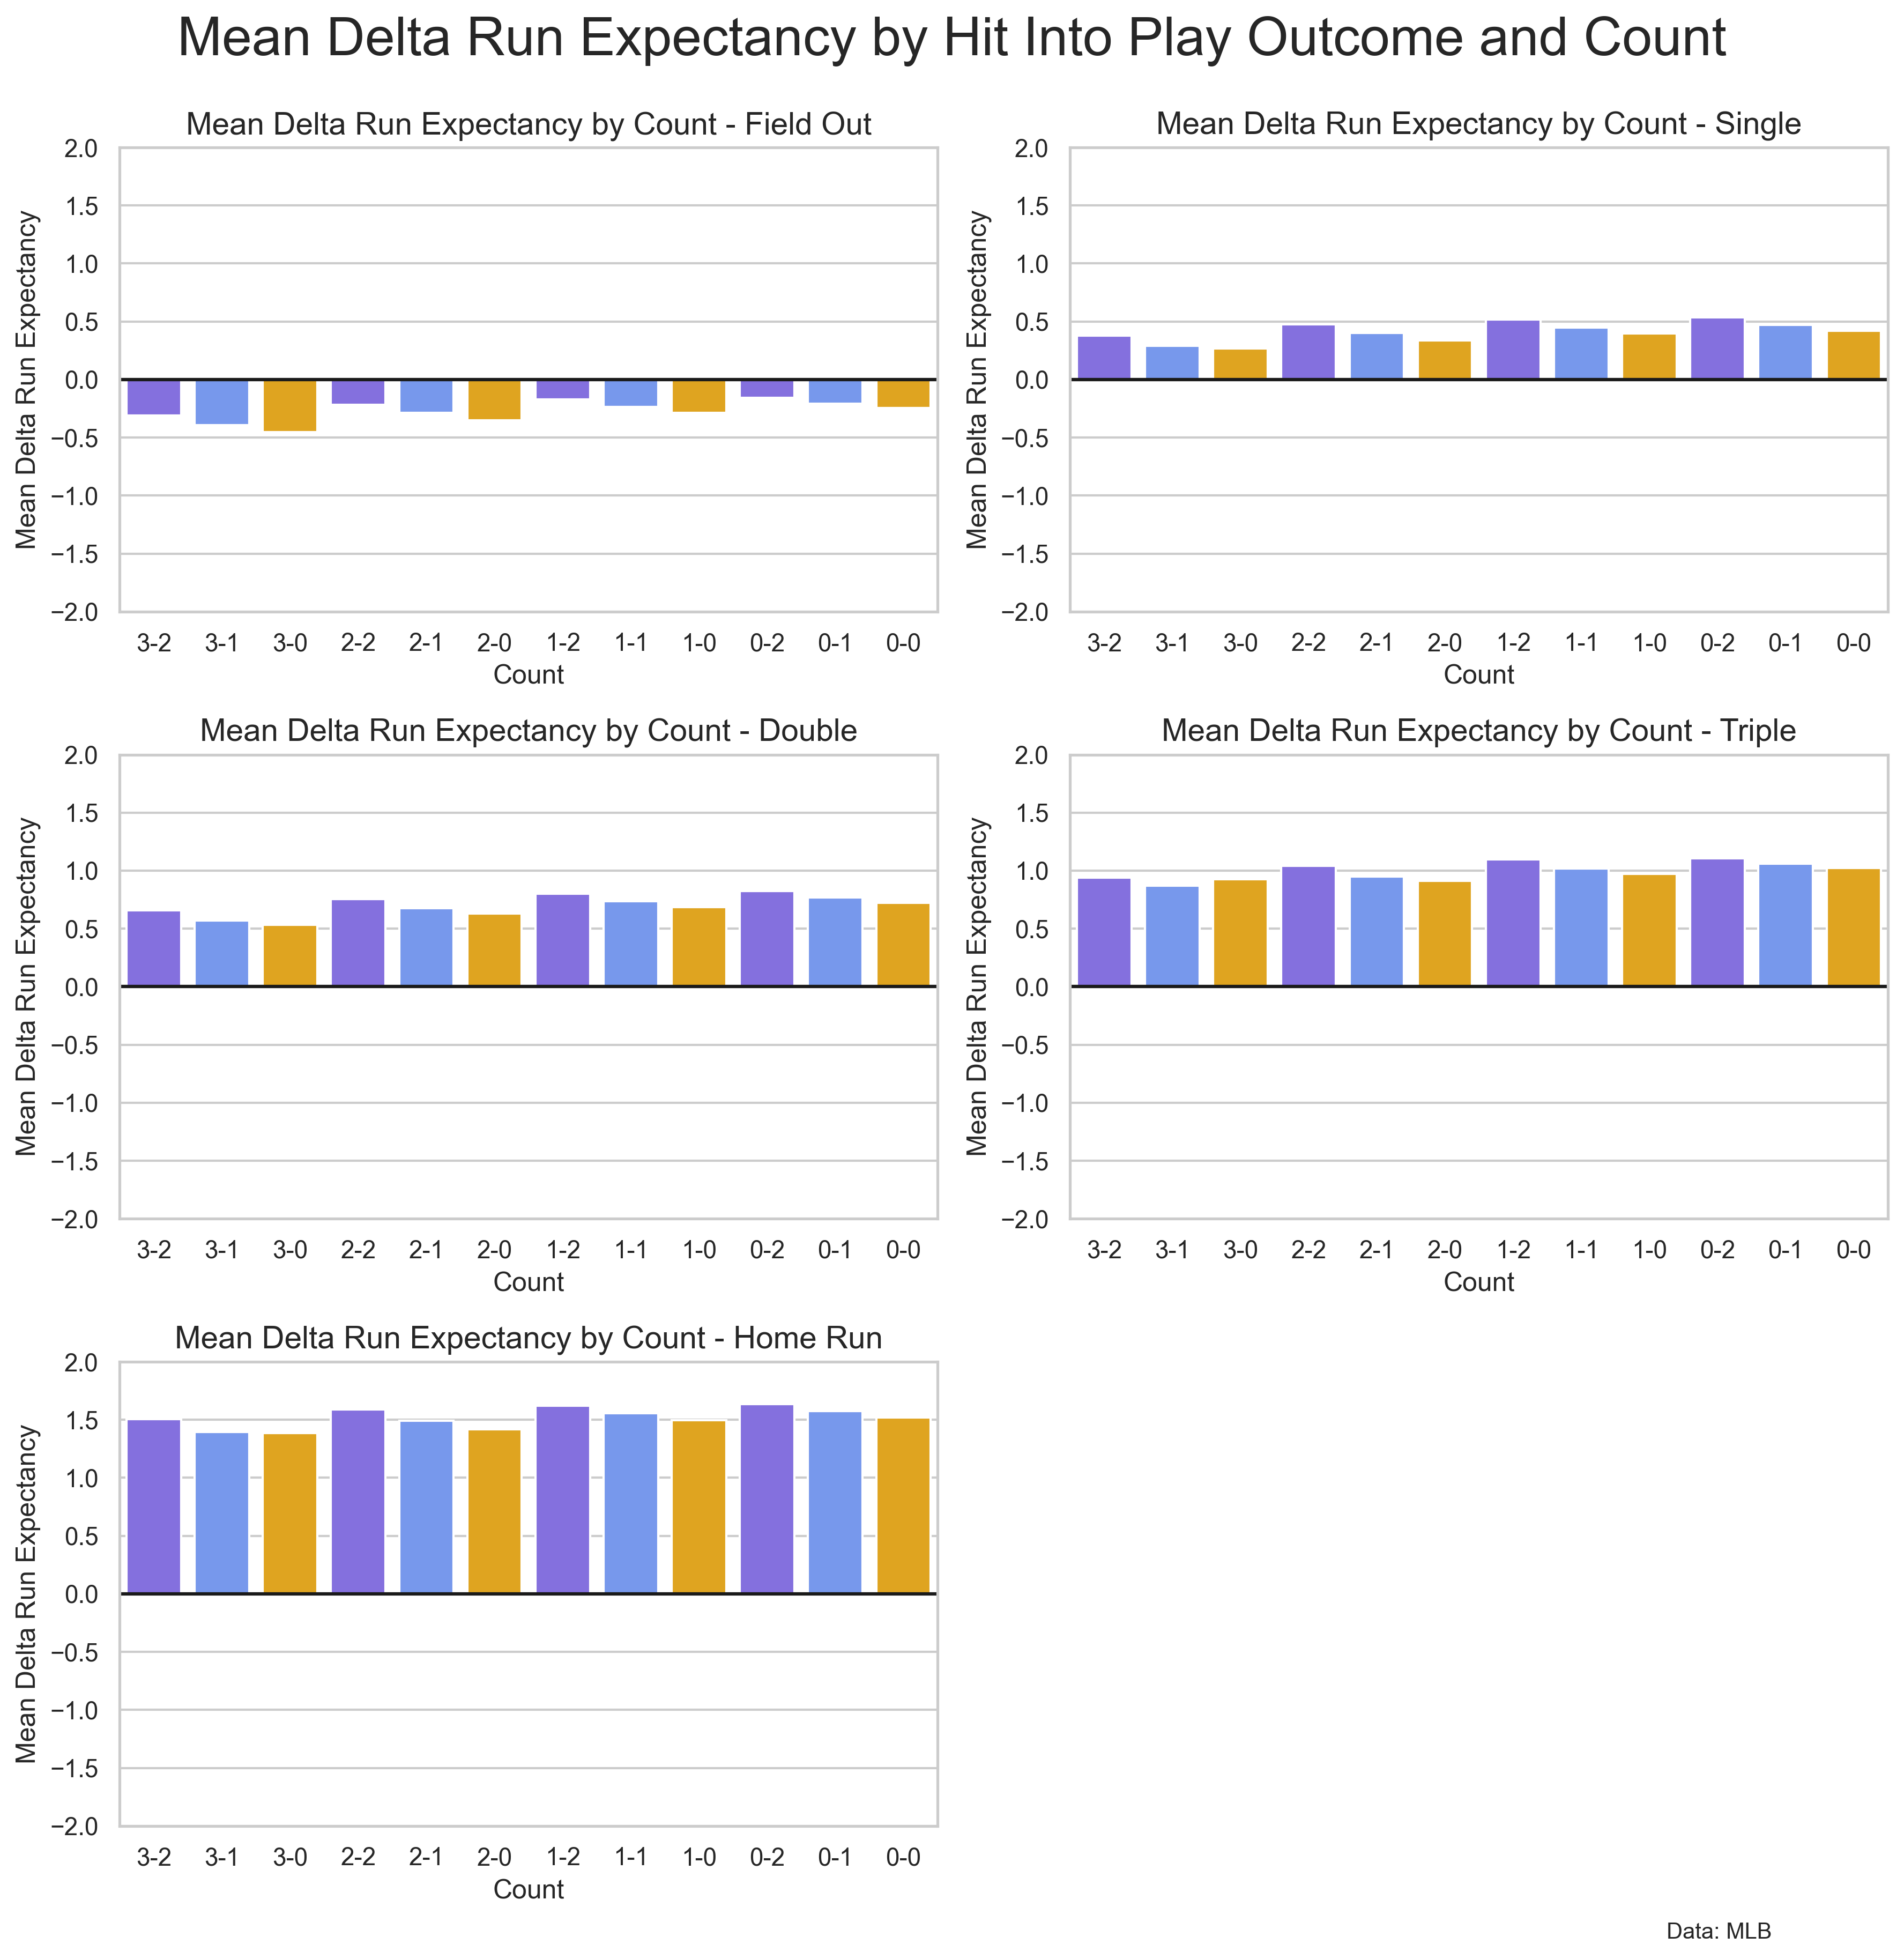

In [12]:
## Create Dataframe to plot Run Expectancies for Hits into Play
outcomes_df_hit = processed_train_data[processed_train_data.description == 'hit_into_play'].groupby(['ev_new', 'strikes', 'balls'])['delta_run_exp_mean'].mean().sort_values().reset_index()
outcomes_df_hit = outcomes_df_hit[outcomes_df_hit.ev_new.isin(processed_train_data[processed_train_data.description == 'hit_into_play'].ev_new.unique())]
outcomes_df_hit = outcomes_df_hit[(outcomes_df_hit.strikes <= 2) & (outcomes_df_hit.balls <= 3)]
outcomes_df_hit['count'] = outcomes_df_hit.balls.astype(str) + '-' + outcomes_df_hit.strikes.astype(str)
outcomes_df_hit = outcomes_df_hit.sort_values(['balls', 'strikes'], ascending = False)


outcome_titles_hit = {'single':'Single',
'field_out':'Field Out',
'double':'Double',
'home_run':'Home Run',
'triple':'Triple'}


sns.set_theme(style = "whitegrid")

fig, ax = plt.subplots(3, 2, figsize = (12, 12), dpi = 300)

axs = ax.flatten()
axs[5].axis('off')
for outx in range(0, len(outcomes_df_hit.ev_new.unique())):
    
    sns.barplot(data = outcomes_df_hit[outcomes_df_hit.ev_new == outcomes_df_hit.ev_new.unique()[outx]],
                y = 'delta_run_exp_mean', x = 'count', hue = 'count', palette = colour_palette[2::-1] * 4, ax = axs[outx])

    axs[outx].set_ylim(-2, 2)
    axs[outx].hlines(y = 0, xmin = -0.5, xmax = 11.5, color = 'k')
    axs[outx].set_xlim(-0.5, 11.5)

    axs[outx].set_xlabel('Count')
    axs[outx].set_ylabel('Mean Delta Run Expectancy')
    axs[outx].set_title(f'Mean Delta Run Expectancy by Count - {outcome_titles_hit[outcomes_df_hit.ev_new.unique()[outx]]}', fontsize = 14)

fig.suptitle(x = 0.5, y = 0.98, t = "Mean Delta Run Expectancy by Hit Into Play Outcome and Count", ha = 'center', va = 'center', fontsize = 24)
fig.text(0.925, 0.00, "Data: MLB", ha = 'right', va = 'center', fontsize = 10)
fig.set_facecolor('white')
fig.tight_layout()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


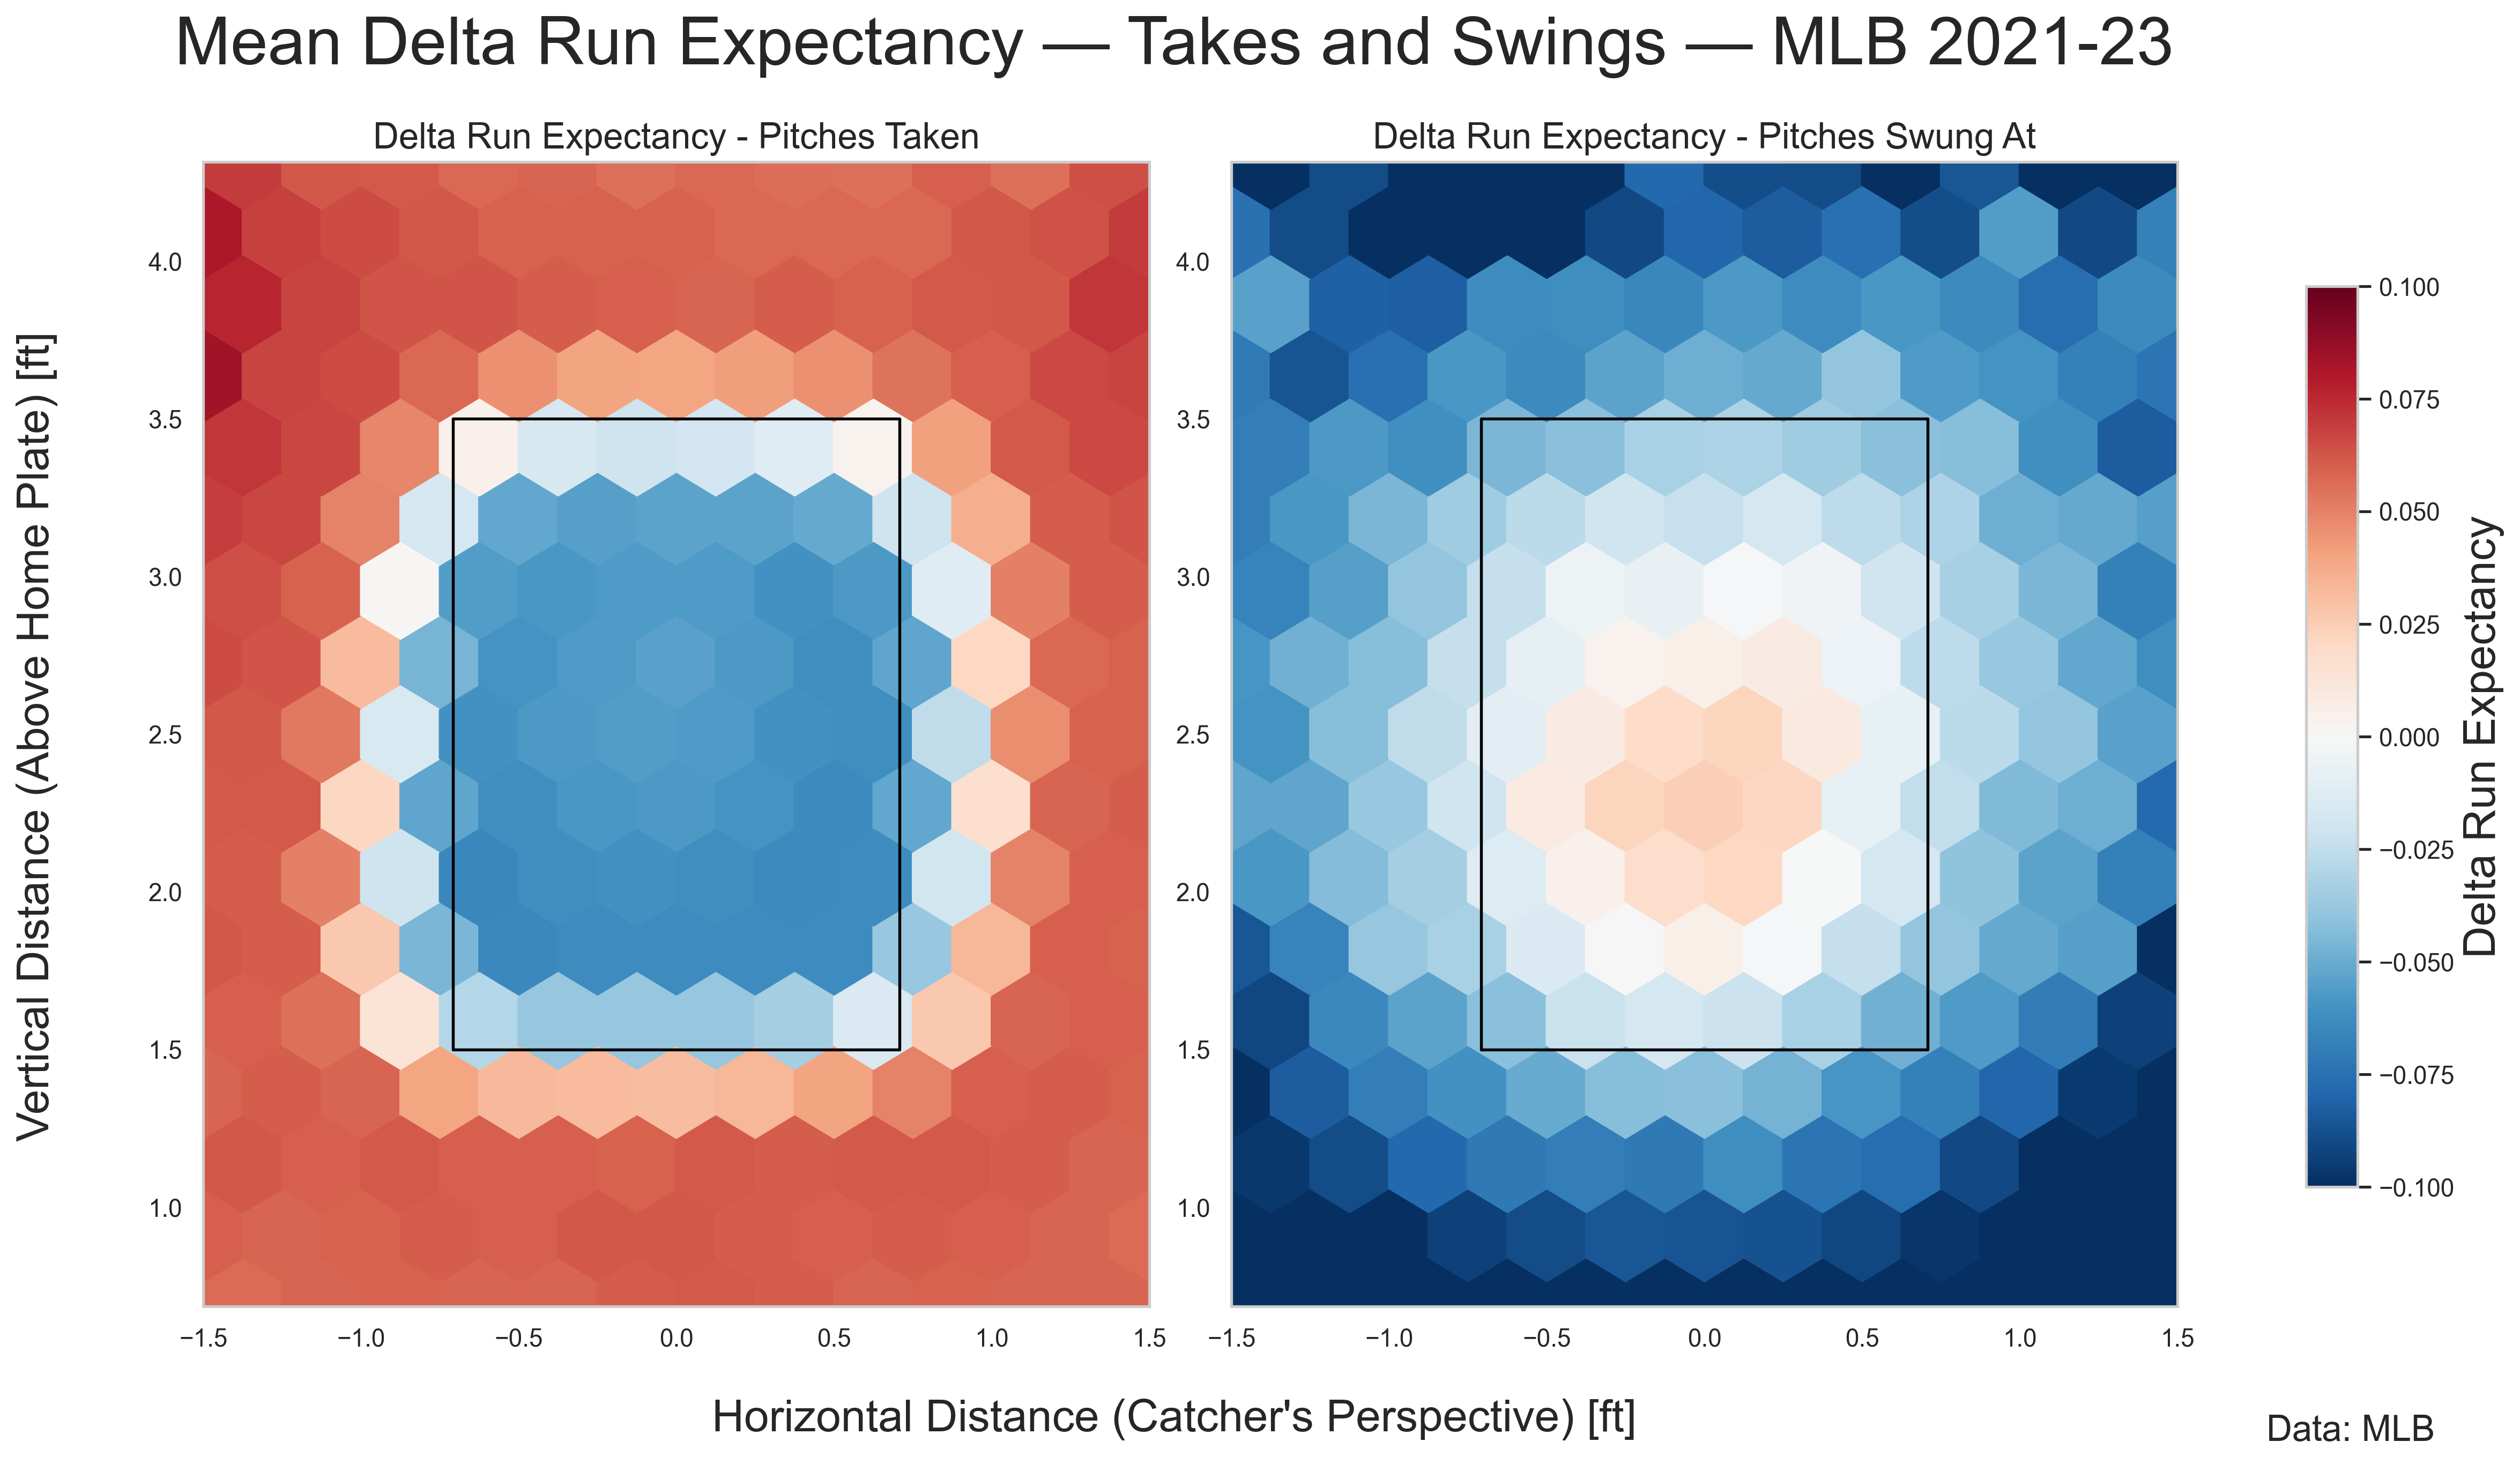

In [13]:
x_min = -2.5
x_max = 2.5
y_min = 0
y_max = 5
extent = [x_min, x_max, y_min, y_max]

# define your scale, with white at zero
vmin = -0.1
vmax = 0.1

#for p_th in range(0,2):
sns.set_theme(style = "whitegrid")
fig, ax = plt.subplots(1, 2, figsize = (16, 8), dpi = 300)
norm = colors.TwoSlopeNorm(vmin = vmin, vcenter = np.array([vmin,vmax]).mean(), vmax = vmax)
#norm = plt.Normalize(vmin,vmax)
sm = plt.cm.ScalarMappable(cmap = 'RdBu_r', norm = norm)


ax[0].hexbin(x = processed_train_data[(processed_train_data.swing == 0)]['plate_x'],
            y = processed_train_data[(processed_train_data.swing == 0)]['plate_z'],
            C = processed_train_data[(processed_train_data.swing == 0)]['delta_run_exp_mean'],
            cmap = 'RdBu_r', norm = norm, extent = extent, gridsize = 20)


ax[1].hexbin(x = processed_train_data[(processed_train_data.swing == 1)]['plate_x'],
            y = processed_train_data[(processed_train_data.swing == 1)]['plate_z'],
            C = processed_train_data[(processed_train_data.swing == 1)]['delta_run_exp_mean'],
            cmap = 'RdBu_r', norm = norm, extent = extent, gridsize = 20)
ax[0].axis('equal')
ax[1].axis('equal')
ax[0].set_xlim(-1.5, 1.5)
ax[1].set_xlim(-1.5, 1.5)

draw_line(ax[0], catcher_p = False)
draw_line(ax[1], catcher_p = False)

ax[0].set_ylim(1, 4)
ax[1].set_ylim(1, 4)

ax[0].set_title('Delta Run Expectancy - Pitches Taken', fontsize = 16)
ax[1].set_title('Delta Run Expectancy - Pitches Swung At', fontsize = 16)
fig.tight_layout()



cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar_big = fig.colorbar(sm, cax = cbar_ax, aspect = 30, shrink = 0.7)
cbar_big.set_label('Delta Run Expectancy', fontsize = 20)

fig.subplots_adjust(right = 0.8)

fig.suptitle(x = 0.41, y = 1.06, t = f"Mean Delta Run Expectancy — Takes and Swings — MLB 2021-23", fontsize = 30)
fig.text(0.41, -0.04, "Horizontal Distance (Catcher's Perspective) [ft]", ha = 'center', fontsize = 20)
fig.text(-0.04, 0.5, "Vertical Distance (Above Home Plate) [ft]", va = 'center', rotation = 'vertical', fontsize = 20)

fig.text(0.9, -0.04, "Data: MLB",ha = 'right', va = 'center', fontsize = 16)
fig.set_facecolor('white')

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


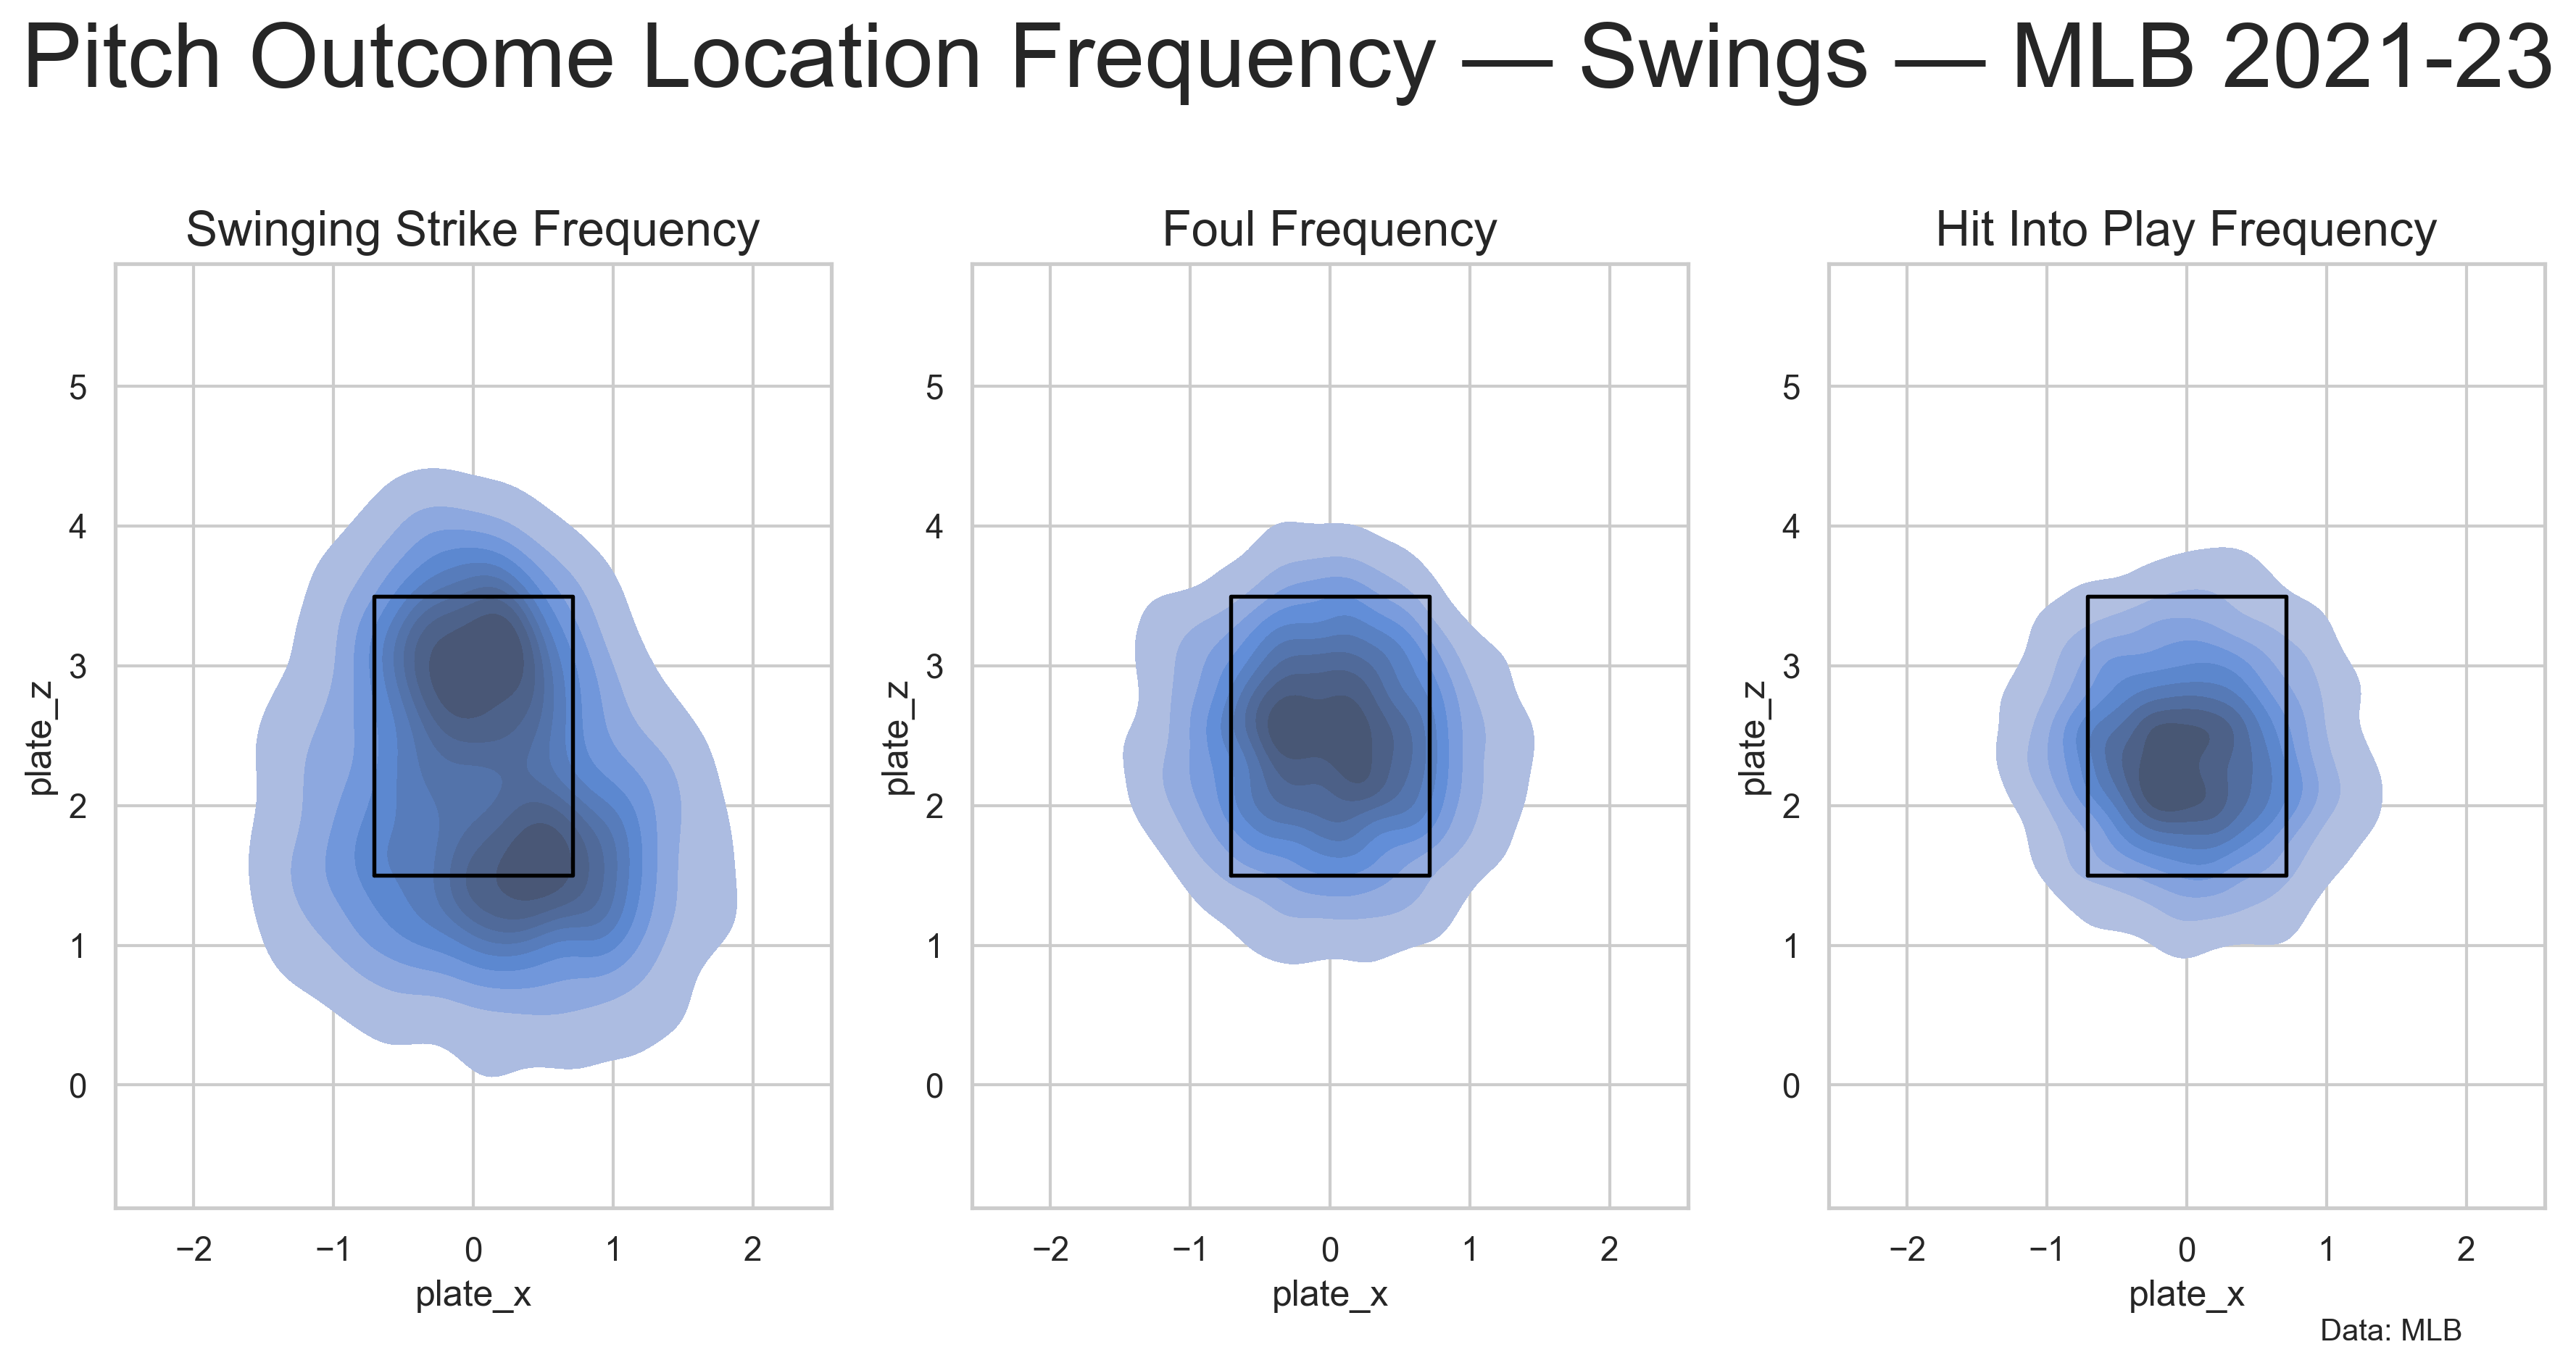

In [14]:
fig, ax = plt.subplots(1, 3, figsize = (12, 6), dpi = 300)

sns.kdeplot(data = processed_train_data[(processed_train_data.des_new == 'swinging_strike') & (processed_train_data.swing == 1)].sample(5000),
    x = 'plate_x',
    y = 'plate_z',
    fill = True,
    ax = ax[0]
)

sns.kdeplot(data = processed_train_data[(processed_train_data.des_new == 'foul') & (processed_train_data.swing == 1)].sample(5000),
    x = 'plate_x',
    y = 'plate_z',
    fill = True,
    ax = ax[1]
)

sns.kdeplot(data = processed_train_data[(processed_train_data.description == 'hit_into_play') & (processed_train_data.swing == 1)].sample(5000),
    x = 'plate_x',
    y = 'plate_z',
    fill = True,
    ax = ax[2]
)

ax[0].axis('equal')
ax[1].axis('equal')
ax[2].axis('equal')
ax[0].set_xlim(-2, 2)
ax[1].set_xlim(-2, 2)
ax[2].set_xlim(-2, 2)

draw_line(ax[0], catcher_p = False)
draw_line(ax[1], catcher_p = False)
draw_line(ax[2], catcher_p = False)


ax[0].set_ylim(0.5, 4.5)
ax[1].set_ylim(0.5, 4.5)
ax[2].set_ylim(0.5, 4.5)

ax[0].set_title('Swinging Strike Frequency', fontsize = 16)
ax[1].set_title('Foul Frequency', fontsize = 16)
ax[2].set_title('Hit Into Play Frequency', fontsize = 16)

fig.suptitle(x = 0.5, y = 1.02, t = f"Pitch Outcome Location Frequency — Swings — MLB 2021-23", fontsize = 30)

fig.text(0.95, 0.015, "Data: MLB",ha = 'right', va = 'center', fontsize = 10)
fig.tight_layout()

### Modeling

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [16]:
def evaluate(model, dtrain, dtest):
    train_pred = model.predict(dtrain)
    train_error = root_mean_squared_error(dtrain.get_label(), train_pred)
    test_pred = model.predict(dtest)
    test_error = root_mean_squared_error(dtest.get_label(), test_pred)

    print(f'Training RMSE: {train_error}\nTesting RMSE: {test_error}')

In [17]:
def sklearn_evaluate(model, x_train, y_train, x_test, y_test):
    train_pred = model.predict(x_train)
    train_error = root_mean_squared_error(y_train, train_pred)
    test_pred = model.predict(x_test)
    test_error = root_mean_squared_error(y_test, test_pred)

    print(f'Training RMSE: {train_error}\nTesting RMSE: {test_error}')

##### Prepare Data For Models

In [18]:
features = ['plate_x', 'plate_z', 'count']
target = 'delta_run_exp_mean'

In [19]:
data_no_swing = processed_train_data.loc[processed_train_data['swing'] != 1, features + [target]]
data_swing = processed_train_data.loc[processed_train_data['swing'] == 1, features + [target]]
data_no_swing = data_no_swing.dropna().reset_index(drop = True)
data_swing = data_swing.dropna().reset_index(drop = True)

x_no_swing = data_no_swing.loc[:, features]
y_no_swing = data_no_swing.loc[:, target]
x_swing = data_swing.loc[:, features]
y_swing = data_swing.loc[:, target]

In [20]:
x_train_no_swing, x_test_no_swing, y_train_no_swing, y_test_no_swing = train_test_split(x_no_swing, y_no_swing, test_size = 0.2, random_state = seed)
x_train_swing, x_test_swing, y_train_swing, y_test_swing = train_test_split(x_swing, y_swing, test_size = 0.2, random_state = seed)

In [21]:
print(x_train_no_swing.shape)
print(x_test_no_swing.shape)
print(x_train_swing.shape)
print(x_test_swing.shape)

(894684, 3)
(223671, 3)
(813517, 3)
(203380, 3)


##### XGBoost

In [22]:
d_train_no_swing = xgb.DMatrix(x_train_no_swing, label = y_train_no_swing, enable_categorical = True)
d_test_no_swing = xgb.DMatrix(x_test_no_swing, label = y_test_no_swing, enable_categorical = True)
d_train_swing = xgb.DMatrix(x_train_swing, label = y_train_swing, enable_categorical = True)
d_test_swing = xgb.DMatrix(x_test_swing, label = y_test_swing, enable_categorical = True)

In [23]:
params = {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.03, 'eval_metric': 'rmse', 'random_state': seed, 'tree_method': 'hist'}
num_rounds = 200

In [24]:
xgb_model_no_swing = xgb.train(params, d_train_no_swing, num_rounds)

In [25]:
evaluate(xgb_model_no_swing, d_train_no_swing, d_test_no_swing) 

Training RMSE: 0.043284062296152115
Testing RMSE: 0.04383387416601181


In [26]:
params = {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.01, 'eval_metric': 'rmse', 'random_state': seed, 'tree_method': 'hist'}
num_rounds = 200

In [27]:
xgb_model_swing = xgb.train(params, d_train_swing, num_rounds)

In [28]:
evaluate(xgb_model_swing, d_train_swing, d_test_swing)

Training RMSE: 0.29615047574043274
Testing RMSE: 0.2976888418197632


##### LightGBM

In [29]:
d_train_no_swing = lgb.Dataset(x_train_no_swing, label = y_train_no_swing)
d_test_no_swing = lgb.Dataset(x_test_no_swing, label = y_test_no_swing)
d_train_swing = lgb.Dataset(x_train_swing, label = y_train_swing)
d_test_swing = lgb.Dataset(x_test_swing, label = y_test_swing)

In [30]:
params = {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.03, 'random_state': seed}
num_rounds = 800

In [31]:
lgb_model_no_swing = lgb.train(params, d_train_no_swing, num_rounds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 894684, number of used features: 3
[LightGBM] [Info] Start training from score 0.021923


In [32]:
sklearn_evaluate(lgb_model_no_swing, x_train_no_swing, y_train_no_swing, x_test_no_swing, y_test_no_swing)

Training RMSE: 0.04370808229850689
Testing RMSE: 0.043729488948126796


In [33]:
params = {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02, 'random_state': seed}
num_rounds = 800

In [34]:
lgb_model_swing = lgb.train(params, d_train_swing, num_rounds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 813517, number of used features: 3
[LightGBM] [Info] Start training from score -0.024035


In [35]:
sklearn_evaluate(lgb_model_swing, x_train_swing, y_train_swing, x_test_swing, y_test_swing)

Training RMSE: 0.2955826491455202
Testing RMSE: 0.2976557129795735


##### The performance of the two models is almost the same. Therefore, I just choosed XGBoost as my model and trained the model using all the data from 2021 to 2023.

In [36]:
d_no_swing = xgb.DMatrix(x_no_swing, label = y_no_swing, enable_categorical = True)
d_swing = xgb.DMatrix(x_swing, label = y_swing, enable_categorical = True)

In [37]:
params_no_swing = {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.03, 'eval_metric': 'rmse', 'random_state': seed, 'tree_method': 'hist'}
num_rounds = 200

In [38]:
xgb_model_no_swing = xgb.train(params_no_swing, d_no_swing, num_rounds)

In [39]:
preds = xgb_model_no_swing.predict(d_no_swing)
print(root_mean_squared_error(d_no_swing.get_label(), preds))

0.04327340051531792


In [40]:
params_swing = {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.01, 'eval_metric': 'rmse', 'random_state': seed, 'tree_method': 'hist'}
num_rounds = 200

In [41]:
xgb_model_swing = xgb.train(params_swing, d_swing, num_rounds)

In [42]:
preds = xgb_model_swing.predict(d_swing)
print(root_mean_squared_error(d_swing.get_label(), preds))

0.29644668102264404


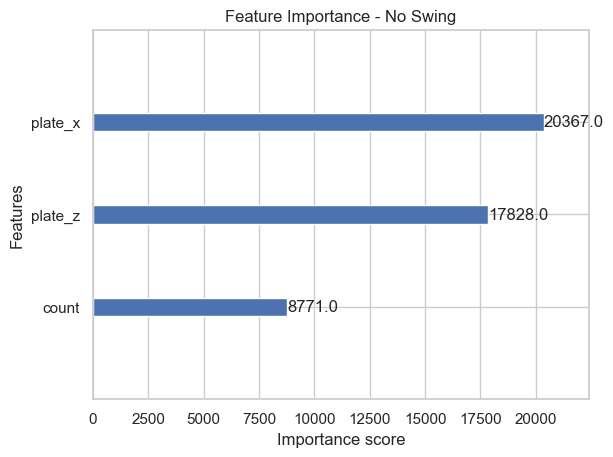

In [43]:
xgb.plot_importance(xgb_model_no_swing)
plt.title('Feature Importance - No Swing')
plt.show()

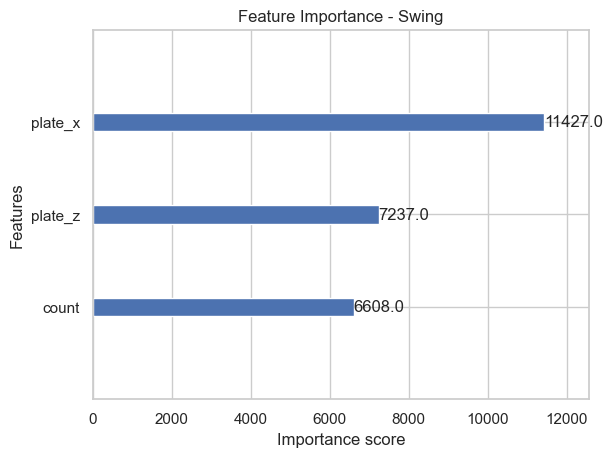

In [44]:
xgb.plot_importance(xgb_model_swing)
plt.title('Feature Importance - Swing')
plt.show()

### Analysis

In [45]:
from pybaseball import playerid_reverse_lookup
from scipy.stats import zscore
from sklearn.metrics import r2_score
import math

In [46]:
def add_batter_name(df):
    batter_data = playerid_reverse_lookup(df['batter'].values)
    batter_data['batter_name'] = batter_data['name_last'] + ', ' + batter_data['name_first']
    batter_data = batter_data.loc[:, ['key_mlbam', 'batter_name']]
    df = df.merge(batter_data, left_on = 'batter', right_on = 'key_mlbam')

    return df

In [47]:
def calculate_player_decision_value(df, min_pitches = None):
    df_grouped = df.groupby(['batter', 'batter_name']).agg(pitches = ('release_speed', 'count'), y_pred = ('y_pred', 'mean'), delta_run_exp = ('delta_run_exp', 'mean'))
    df_grouped = df_grouped.reset_index()

    df_grouped.loc[:, 'decision_value'] = zscore(df_grouped['y_pred'].values)
    df_grouped.loc[:, 'decision_value'] = 100 + df_grouped['decision_value'] * 10

    if min_pitches:
        df_grouped = df_grouped.loc[df_grouped['pitches'] >= min_pitches, :]

    return df_grouped

In [48]:
def evaluate_stabilization_by_player(df, player_col, value_col, 
                                     min_size = 10, max_size = 500, step = 10, 
                                     players_per_group = 100, threshold = 0.7):
    results = []

    for sample_size in tqdm(range(min_size, max_size + 1, step)):

        sampled_players = np.random.choice(df[player_col].unique(), players_per_group, replace = False)
        pitch_matrix = []

        for player in sampled_players:
            player_vals = df[df[player_col] == player][value_col]
            pitch_sample = player_vals.sample(sample_size, replace = True).values
            pitch_matrix.append(pitch_sample)

        if len(pitch_matrix) == players_per_group:
            df_alpha = pd.DataFrame(pitch_matrix)
            alpha, _ = pg.cronbach_alpha(data = df_alpha)  # transpose so raters are rows

        results.append({'sample_size': sample_size, 'cronbach_alpha': alpha})
        if alpha >= threshold:
            break

    return pd.DataFrame(results)

In [49]:
processed_train_data = add_batter_name(processed_train_data)
processed_test_data = add_batter_name(processed_test_data)

Gathering player lookup table. This may take a moment.


In [50]:
processed_train_data.loc[processed_train_data['swing'] == 0, 'y_pred'] = xgb_model_no_swing.predict(xgb.DMatrix(processed_train_data.loc[processed_train_data['swing'] == 0, features], enable_categorical = True))
processed_train_data.loc[processed_train_data['swing'] == 1, 'y_pred'] = xgb_model_swing.predict(xgb.DMatrix(processed_train_data.loc[processed_train_data['swing'] == 1, features], enable_categorical = True))

In [51]:
processed_test_data.loc[processed_test_data['swing'] == 0, 'y_pred'] = xgb_model_no_swing.predict(xgb.DMatrix(processed_test_data.loc[processed_test_data['swing'] == 0, features], enable_categorical = True))
processed_test_data.loc[processed_test_data['swing'] == 1, 'y_pred'] = xgb_model_swing.predict(xgb.DMatrix(processed_test_data.loc[processed_test_data['swing'] == 1, features], enable_categorical = True))

In [ ]:
min_size = 500

processed_data_2023 = processed_train_data.loc[processed_train_data['game_date'] > '2023-01-01', :]
processed_data_2023_grouped = processed_data_2023.groupby(['batter']).agg(pitches = ('release_speed', 'count'))
processed_data_2023_grouped = processed_data_2023_grouped.reset_index()
qulified_batters = processed_data_2023_grouped.loc[processed_data_2023_grouped['pitches'] >= min_size, 'batter']

In [53]:
results = evaluate_stabilization_by_player(processed_data_2023.loc[processed_data_2023['batter'].isin(qulified_batters), :], 'batter', 'y_pred')
print(results)

  0%|          | 0/50 [00:00<?, ?it/s]

    sample_size  cronbach_alpha
0            10       -0.073166
1            20        0.157428
2            30        0.242151
3            40        0.078716
4            50        0.188771
5            60        0.263285
6            70        0.250057
7            80        0.254446
8            90        0.119678
9           100        0.338518
10          110        0.316177
11          120        0.381893
12          130        0.215426
13          140        0.361040
14          150        0.422499
15          160        0.304679
16          170        0.425702
17          180        0.445450
18          190        0.471609
19          200        0.507467
20          210        0.488611
21          220        0.458781
22          230        0.540369
23          240        0.552552
24          250        0.558767
25          260        0.408690
26          270        0.434736
27          280        0.579250
28          290        0.494283
29          300        0.527228
30      

##### With 400 pitches, Cronbach's Alpha can reach over 0.7. This means that my swing decision value is sufficiently sticky.

In [54]:
processed_data_2022 = processed_train_data.loc[(processed_train_data['game_date'] > '2022-01-01') & (processed_train_data['game_date'] < '2022-12-31'), :]

In [55]:
processed_data_2023_grouped = calculate_player_decision_value(processed_data_2023, min_pitches = 500)
processed_data_2022_grouped = calculate_player_decision_value(processed_data_2022, min_pitches = 500)

In [56]:
processed_data_2022_2023_grouped = pd.merge(processed_data_2022_grouped, processed_data_2023_grouped, how = 'inner', on = 'batter', suffixes =  ('_2022', '_2023'))

In [57]:
r2_result = np.power(np.corrcoef(processed_data_2022_2023_grouped['decision_value_2022'].values, processed_data_2022_2023_grouped['decision_value_2023'].values)[0][1], 2)

Text(0.05, 0.9, '$R^2$ = 0.57')

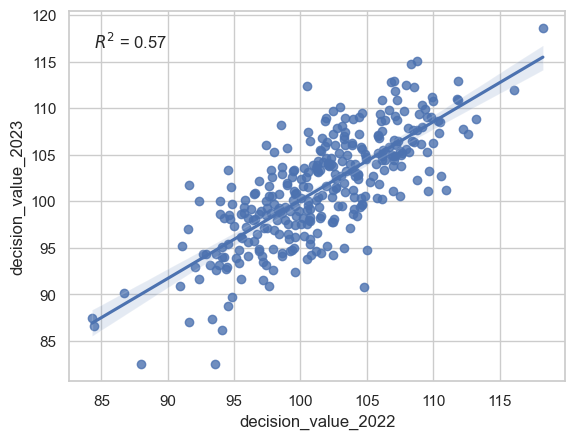

In [58]:
ax = sns.regplot(x = 'decision_value_2022', y = 'decision_value_2023', data = processed_data_2022_2023_grouped)
ax.text(0.05, 0.9, f'$R^2$ = {r2_result:.2f}', transform = ax.transAxes)

##### The decision value is sticky enough year to year, too.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


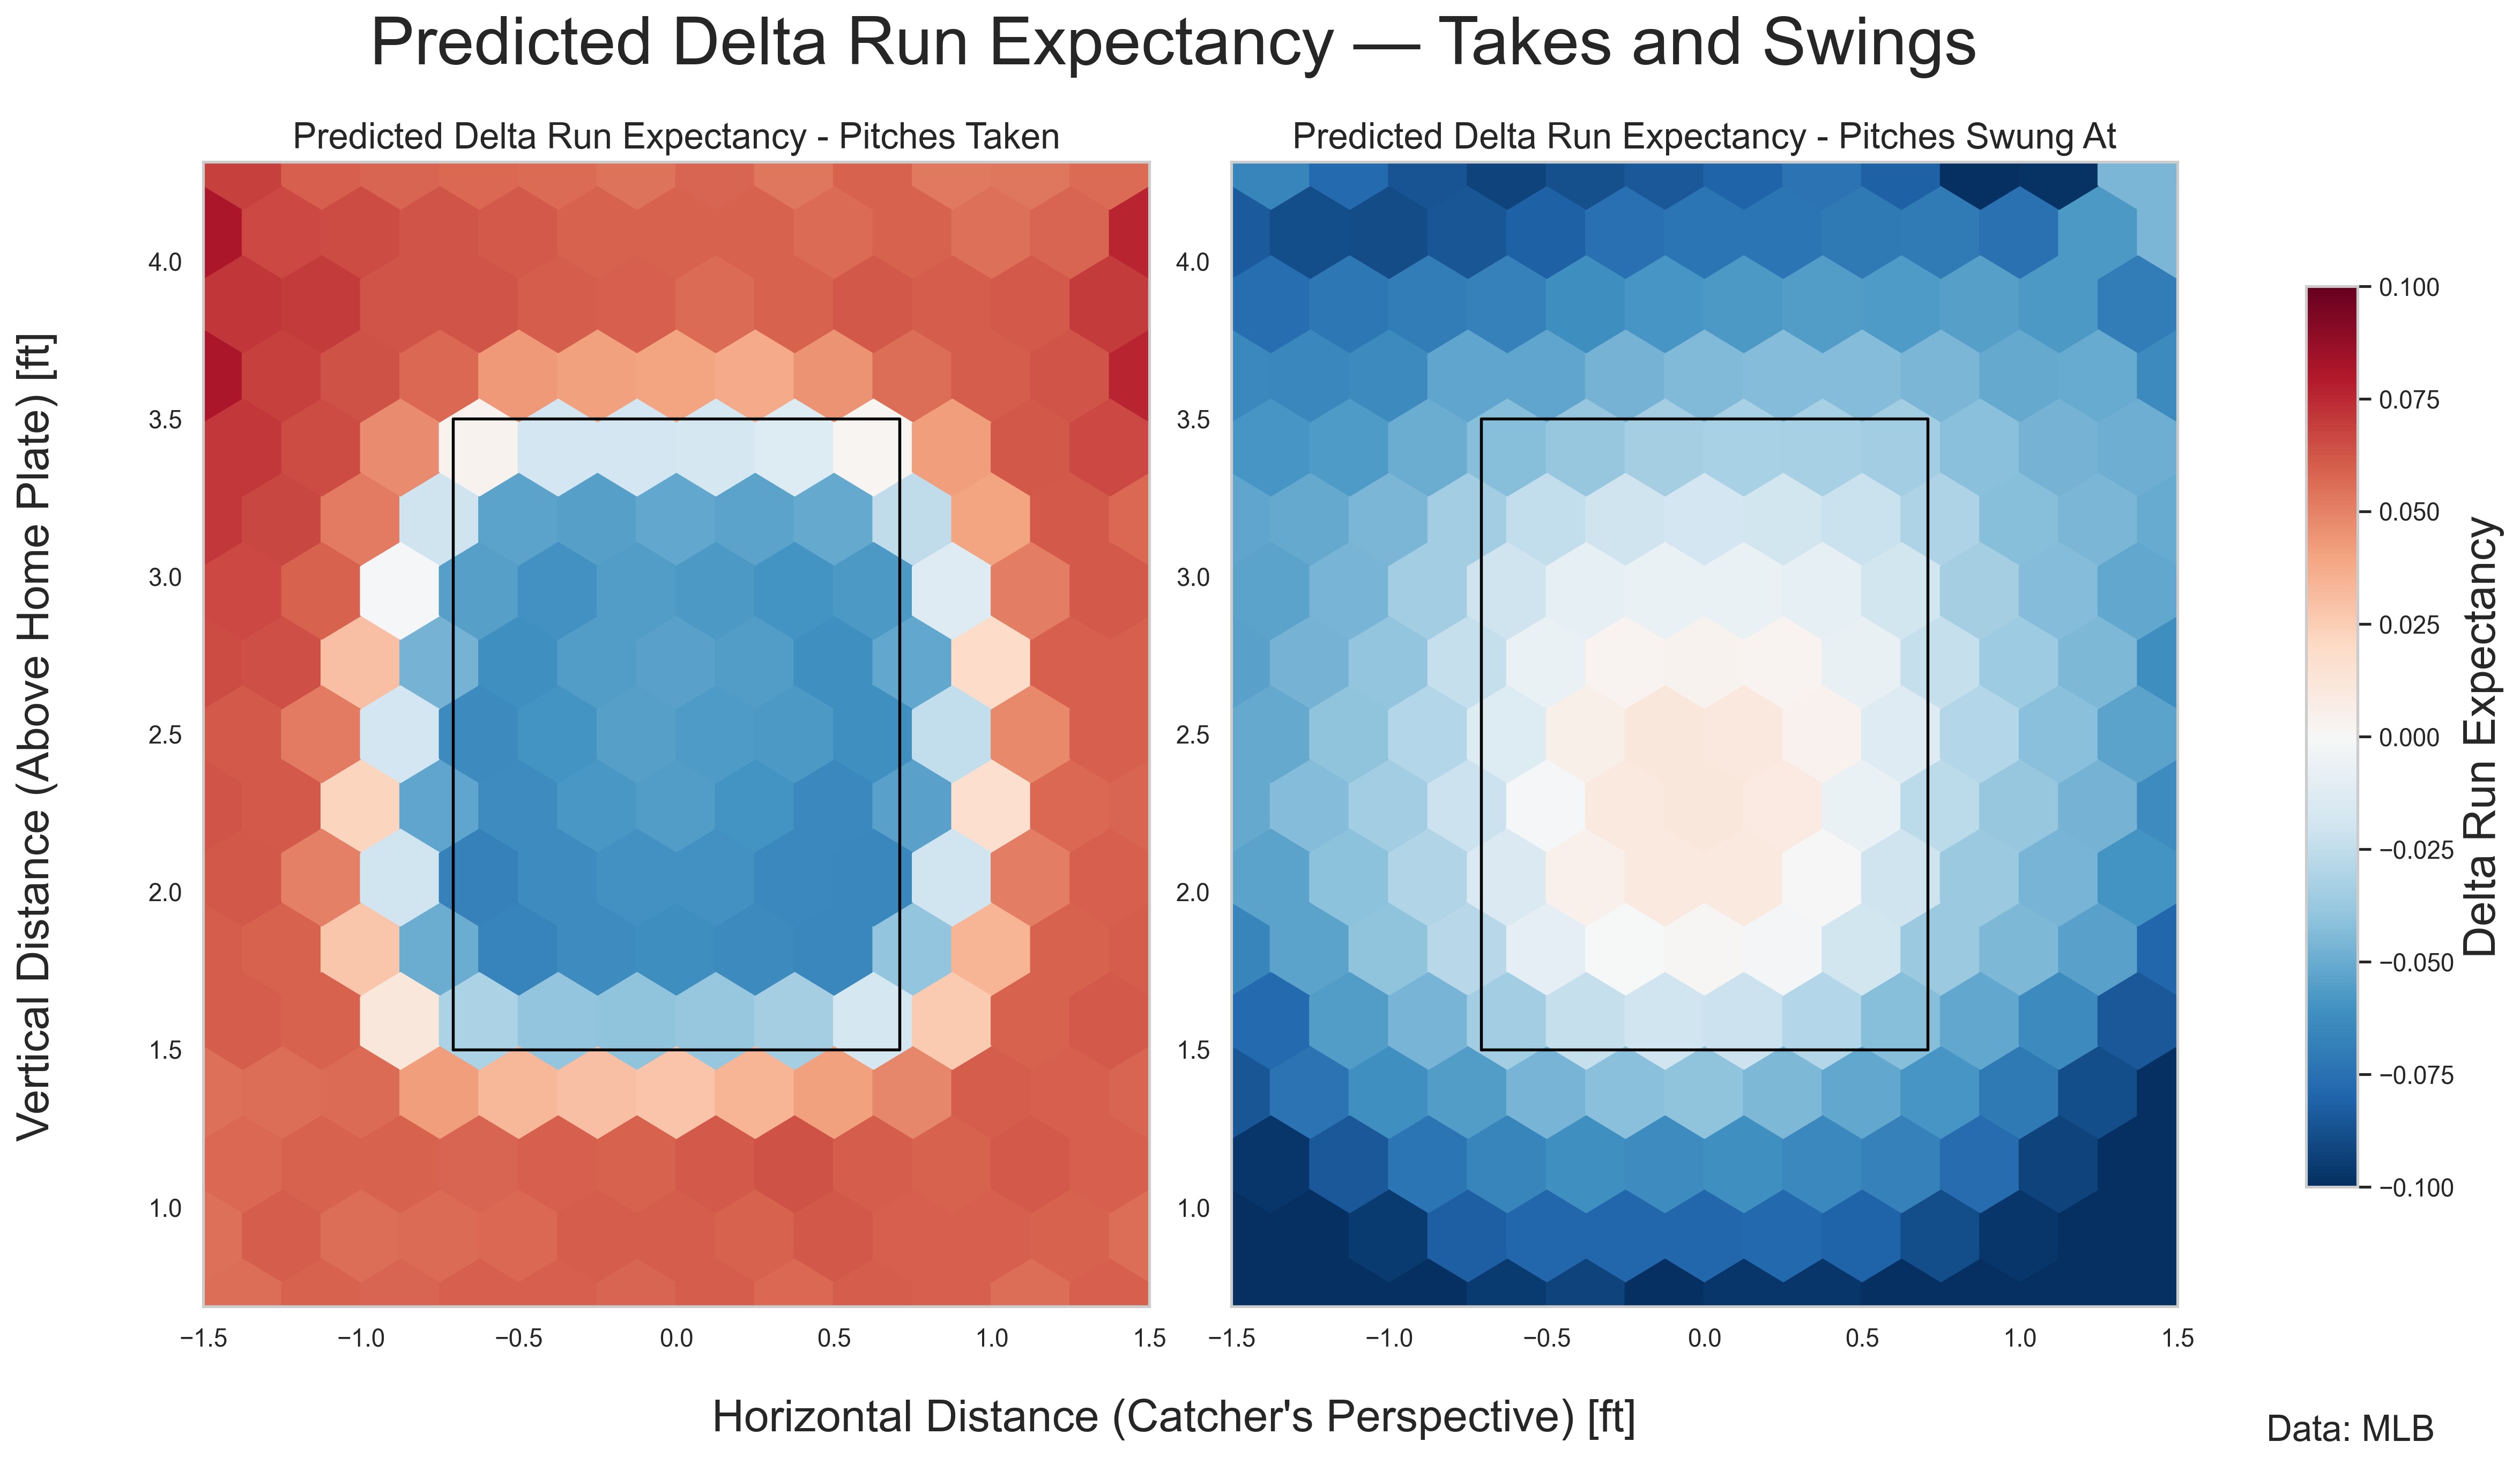

In [59]:
x_min = -2.5
x_max = 2.5
y_min = 0
y_max = 5
extent = [x_min, x_max, y_min, y_max]

# define your scale, with white at zero
vmin = -0.1
vmax = 0.1

#for p_th in range(0,2):
sns.set_theme(style = "whitegrid")
fig, ax = plt.subplots(1, 2, figsize = (16, 8), dpi = 300)
norm = colors.TwoSlopeNorm(vmin = vmin, vcenter = np.array([vmin,vmax]).mean(), vmax = vmax)
#norm = plt.Normalize(vmin,vmax)
sm = plt.cm.ScalarMappable(cmap = 'RdBu_r', norm = norm)


ax[0].hexbin(x = processed_test_data[(processed_test_data.swing == 0)]['plate_x'],
            y = processed_test_data[(processed_test_data.swing == 0)]['plate_z'],
            C = processed_test_data[(processed_test_data.swing == 0)]['y_pred'],
            cmap = 'RdBu_r', norm = norm, extent = extent, gridsize = 20)


ax[1].hexbin(x = processed_test_data[(processed_test_data.swing == 1)]['plate_x'],
            y = processed_test_data[(processed_test_data.swing == 1)]['plate_z'],
            C = processed_test_data[(processed_test_data.swing == 1)]['y_pred'],
            cmap = 'RdBu_r', norm = norm, extent = extent, gridsize = 20)
ax[0].axis('equal')
ax[1].axis('equal')
ax[0].set_xlim(-1.5, 1.5)
ax[1].set_xlim(-1.5, 1.5)

draw_line(ax[0], catcher_p = False)
draw_line(ax[1], catcher_p = False)

ax[0].set_ylim(1, 4)
ax[1].set_ylim(1, 4)

ax[0].set_title('Predicted Delta Run Expectancy - Pitches Taken', fontsize = 16)
ax[1].set_title('Predicted Delta Run Expectancy - Pitches Swung At', fontsize = 16)
fig.tight_layout()



cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar_big = fig.colorbar(sm, cax = cbar_ax, aspect = 30, shrink = 0.7)
cbar_big.set_label('Delta Run Expectancy', fontsize = 20)

fig.subplots_adjust(right = 0.8)

fig.suptitle(x = 0.41, y = 1.06, t = f"Predicted Delta Run Expectancy — Takes and Swings", fontsize = 30)
fig.text(0.41, -0.04, "Horizontal Distance (Catcher's Perspective) [ft]", ha = 'center', fontsize = 20)
fig.text(-0.04, 0.5, "Vertical Distance (Above Home Plate) [ft]", va = 'center', rotation = 'vertical', fontsize = 20)

fig.text(0.9, -0.04, "Data: MLB",ha = 'right', va = 'center', fontsize = 16)
fig.set_facecolor('white')

In [60]:
data_2024_grouped = calculate_player_decision_value(processed_test_data, min_pitches = 500)

In [61]:
data_2024_grouped.sort_values(by = 'decision_value', ascending = False).head(10)

batter       batter_name  pitches    y_pred  delta_run_exp  \
323  665742        soto, juan     2957  0.011108       0.024599   
281  663656      tucker, kyle     1349  0.010197       0.024215   
138  621466       stewart, dj      765  0.007626      -0.001318   
187  642136      thaiss, matt      754  0.007347      -0.004859   
526  680700  palacios, richie     1280  0.006995      -0.001710   
132  621035     taylor, chris     1046  0.006443      -0.007132   
257  660670     acuña, ronald      905  0.006415       0.004970   
56   571970        muncy, max     1154  0.006354       0.009020   
204  643565    tauchman, mike     1537  0.006318       0.000980   
200  643376     jansen, danny     1367  0.006286      -0.001986   

     decision_value  
323      121.221390  
281      119.676117  
138      115.318344  
187      114.846306  
526      114.249390  
132      113.314117  
257      113.265236  
56       113.162643  
204      113.100891  
200      113.046936

In [62]:
data_2024_grouped.sort_values(by = 'decision_value', ascending = False).tail(10)

batter             batter_name  pitches    y_pred  delta_run_exp  \
482  676391          clement, ernie     1449 -0.007383      -0.001336   
258  660688           ruiz, keibert     1659 -0.007475      -0.010876   
465  672820             sosa, lenyn     1377 -0.007704      -0.008418   
560  682641             matos, luis      544 -0.007705      -0.009864   
25   542194  bethancourt, christian      516 -0.007889      -0.012188   
515  678877         noel, jhonkensy      725 -0.008006       0.005981   
518  679032            rojas, johan     1329 -0.008296      -0.005881   
516  678882       rafaela, ceddanne     2070 -0.008617      -0.003290   
153  623912         ramírez, harold      878 -0.009886      -0.013097   
86   595879            báez, javier     1020 -0.010322      -0.019692   

     decision_value  
482       89.878136  
258       89.721436  
465       89.334404  
560       89.331322  
25        89.019501  
515       88.821259  
518       88.330299  
516       87.785934  
153       85.635254  
86        84.896294

In [63]:
data_2024_swing_grouped = calculate_player_decision_value(processed_test_data.loc[processed_test_data['swing'] == 1, :], min_pitches = 500)

In [64]:
data_2024_swing_grouped.sort_values(by = 'decision_value', ascending = False).head(10)

batter         batter_name  pitches    y_pred  delta_run_exp  \
54   571771  hernández, enrique      736 -0.016351      -0.027651   
523  680474      schuemann, max      780 -0.018359      -0.041391   
173  641584        fraley, jake      771 -0.018423      -0.028994   
39   543807    springer, george     1128 -0.018596      -0.031764   
268  663457      nootbaar, lars      617 -0.018659      -0.014710   
130  621020     swanson, dansby     1148 -0.018706      -0.029640   
382  668930       turang, brice     1178 -0.018787      -0.025939   
435  670770          friedl, tj      558 -0.018871      -0.028306   
97   602104        urías, ramón      570 -0.018888      -0.022168   
234  656582         joe, connor      712 -0.019018      -0.027674   

     decision_value  
54       112.727829  
523      108.837181  
173      108.714195  
39       108.377602  
268      108.256104  
130      108.165276  
382      108.007492  
435      107.846474  
97       107.812050  
234      107.560806

In [65]:
data_2024_swing_grouped.sort_values(by = 'decision_value', ascending = False).tail(10)

batter         batter_name  pitches    y_pred  delta_run_exp  \
162  624641       sosa, edmundo      596 -0.028404      -0.016681   
154  624413        alonso, pete     1192 -0.028543      -0.012590   
117  608070       ramírez, josé     1352 -0.028602      -0.001863   
13   514888        altuve, josé     1263 -0.028616      -0.010036   
250  657757       sheets, gavin      964 -0.028778      -0.033149   
153  623993  santander, anthony     1362 -0.029015      -0.002839   
257  660688       ruiz, keibert      867 -0.029358      -0.034081   
22   521692     pérez, salvador     1330 -0.030213      -0.012641   
21   519317  stanton, giancarlo      855 -0.030460      -0.010965   
86   595879        báez, javier      535 -0.034901      -0.051477   

     decision_value  
162       89.375427  
154       89.104996  
117       88.990562  
13        88.963356  
250       88.650284  
153       88.190826  
257       87.525238  
22        85.868431  
21        85.390739  
86        76.786133

In [66]:
data_2024_no_swing_grouped = calculate_player_decision_value(processed_test_data.loc[processed_test_data['swing'] == 0, :], min_pitches = 500)

In [67]:
data_2024_no_swing_grouped.sort_values(by = 'decision_value', ascending = False).head(10)

batter        batter_name  pitches    y_pred  delta_run_exp  \
44   547180      harper, bryce     1164  0.035559       0.036121   
121  608369      seager, corey      879  0.034144       0.035330   
281  663656       tucker, kyle      785  0.033338       0.032034   
16   518692   freeman, freddie     1243  0.032474       0.034080   
206  645277      albies, ozzie      716  0.032055       0.035257   
22   521692    pérez, salvador      971  0.031856       0.027822   
174  641584       fraley, jake      560  0.031655       0.033213   
38   543760     semien, marcus     1313  0.031556       0.030641   
298  664040      lowe, brandon      726  0.031186       0.032978   
59   572233  walker, christian     1203  0.031090       0.030062   

     decision_value  
44       117.448059  
121      115.941727  
281      115.082970  
16       114.162888  
206      113.716652  
22       113.505028  
174      113.291512  
38       113.185844  
298      112.792038  
59       112.689590

In [68]:
data_2024_no_swing_grouped.sort_values(by = 'decision_value', ascending = False).tail(10)

batter          batter_name  pitches    y_pred  delta_run_exp  \
195  642731      estrada, thairo      637  0.011974       0.012187   
286  663743         fortes, nick      585  0.011625       0.012039   
32   543257     grossman, robbie      657  0.011343       0.017702   
576  686217         frelick, sal     1196  0.010946       0.010995   
638  696285         young, jacob     1078  0.010831       0.014280   
284  663698           bart, joey      635  0.010635       0.014828   
202  643396  kiner-falefa, isiah      916  0.010464       0.008246   
17   518735     grandal, yasmani      563  0.010370       0.012813   
156  624415        biggio, cavan      590  0.008949       0.011122   
517  679032         rojas, johan      681  0.007905       0.006455   

     decision_value  
195       92.335373  
286       91.963959  
32        91.663078  
576       91.240311  
638       91.118546  
284       90.909485  
202       90.727249  
17        90.627304  
156       89.114075  
517       88.002274

In [69]:
all_data_2024_swing_grouped = calculate_player_decision_value(processed_test_data.loc[processed_test_data['swing'] == 1, :])
all_data_2024_no_swing_grouped = calculate_player_decision_value(processed_test_data.loc[processed_test_data['swing'] == 0, :])
all_data_2024_swing_plus_no_grouped = all_data_2024_swing_grouped.merge(all_data_2024_no_swing_grouped, on = 'batter', suffixes = ['_swing', '_no_swing'])

In [70]:
all_data_2024_swing_plus_no_grouped['decision_value_overall'] = ((all_data_2024_swing_plus_no_grouped['y_pred_no_swing'] * all_data_2024_swing_plus_no_grouped['pitches_no_swing']) + \
                                                                (all_data_2024_swing_plus_no_grouped['y_pred_swing'] * all_data_2024_swing_plus_no_grouped['pitches_swing'])) / \
                                                                (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'])
all_data_2024_swing_plus_no_grouped['decision_value_overall'] = zscore(all_data_2024_swing_plus_no_grouped['decision_value_overall'].values)
all_data_2024_swing_plus_no_grouped['decision_value_overall'] = 100 + all_data_2024_swing_plus_no_grouped['decision_value_overall'] * 10 

In [71]:
min_pitches = 500
all_data_2024_swing_plus_no_grouped = all_data_2024_swing_plus_no_grouped.loc[(all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing']) > min_pitches, :]

In [72]:
all_data_2024_swing_plus_no_grouped.head()

batter  batter_name_swing  pitches_swing  y_pred_swing  \
0  444482     peralta, david            516     -0.022643   
1  453568  blackmon, charlie            920     -0.026336   
2  455117  maldonado, martín            274     -0.020596   
3  456781    solano, donovan            601     -0.022101   
4  457705  mccutchen, andrew            908     -0.019546   

   delta_run_exp_swing  decision_value_swing batter_name_no_swing  \
0            -0.019506            100.537369       peralta, david   
1            -0.017666             93.381432    blackmon, charlie   
2            -0.070073            104.502800    maldonado, martín   
3            -0.009200            101.586967      solano, donovan   
4            -0.020311            106.537964    mccutchen, andrew   

   pitches_no_swing  y_pred_no_swing  delta_run_exp_no_swing  \
0               498         0.026729                0.024699   
1               999         0.022778                0.025179   
2               282         0.008834                0.008624   
3               672         0.018817                0.017955   
4              1255         0.022269                0.021920   

   decision_value_no_swing  decision_value_overall  
0               108.045715              105.887089  
1               103.838852              101.020987  
2                88.991982               90.970257  
3                99.621811              101.569215  
4               103.297173              112.266592

Text(0.875, 0.085, 'Data: MLB')

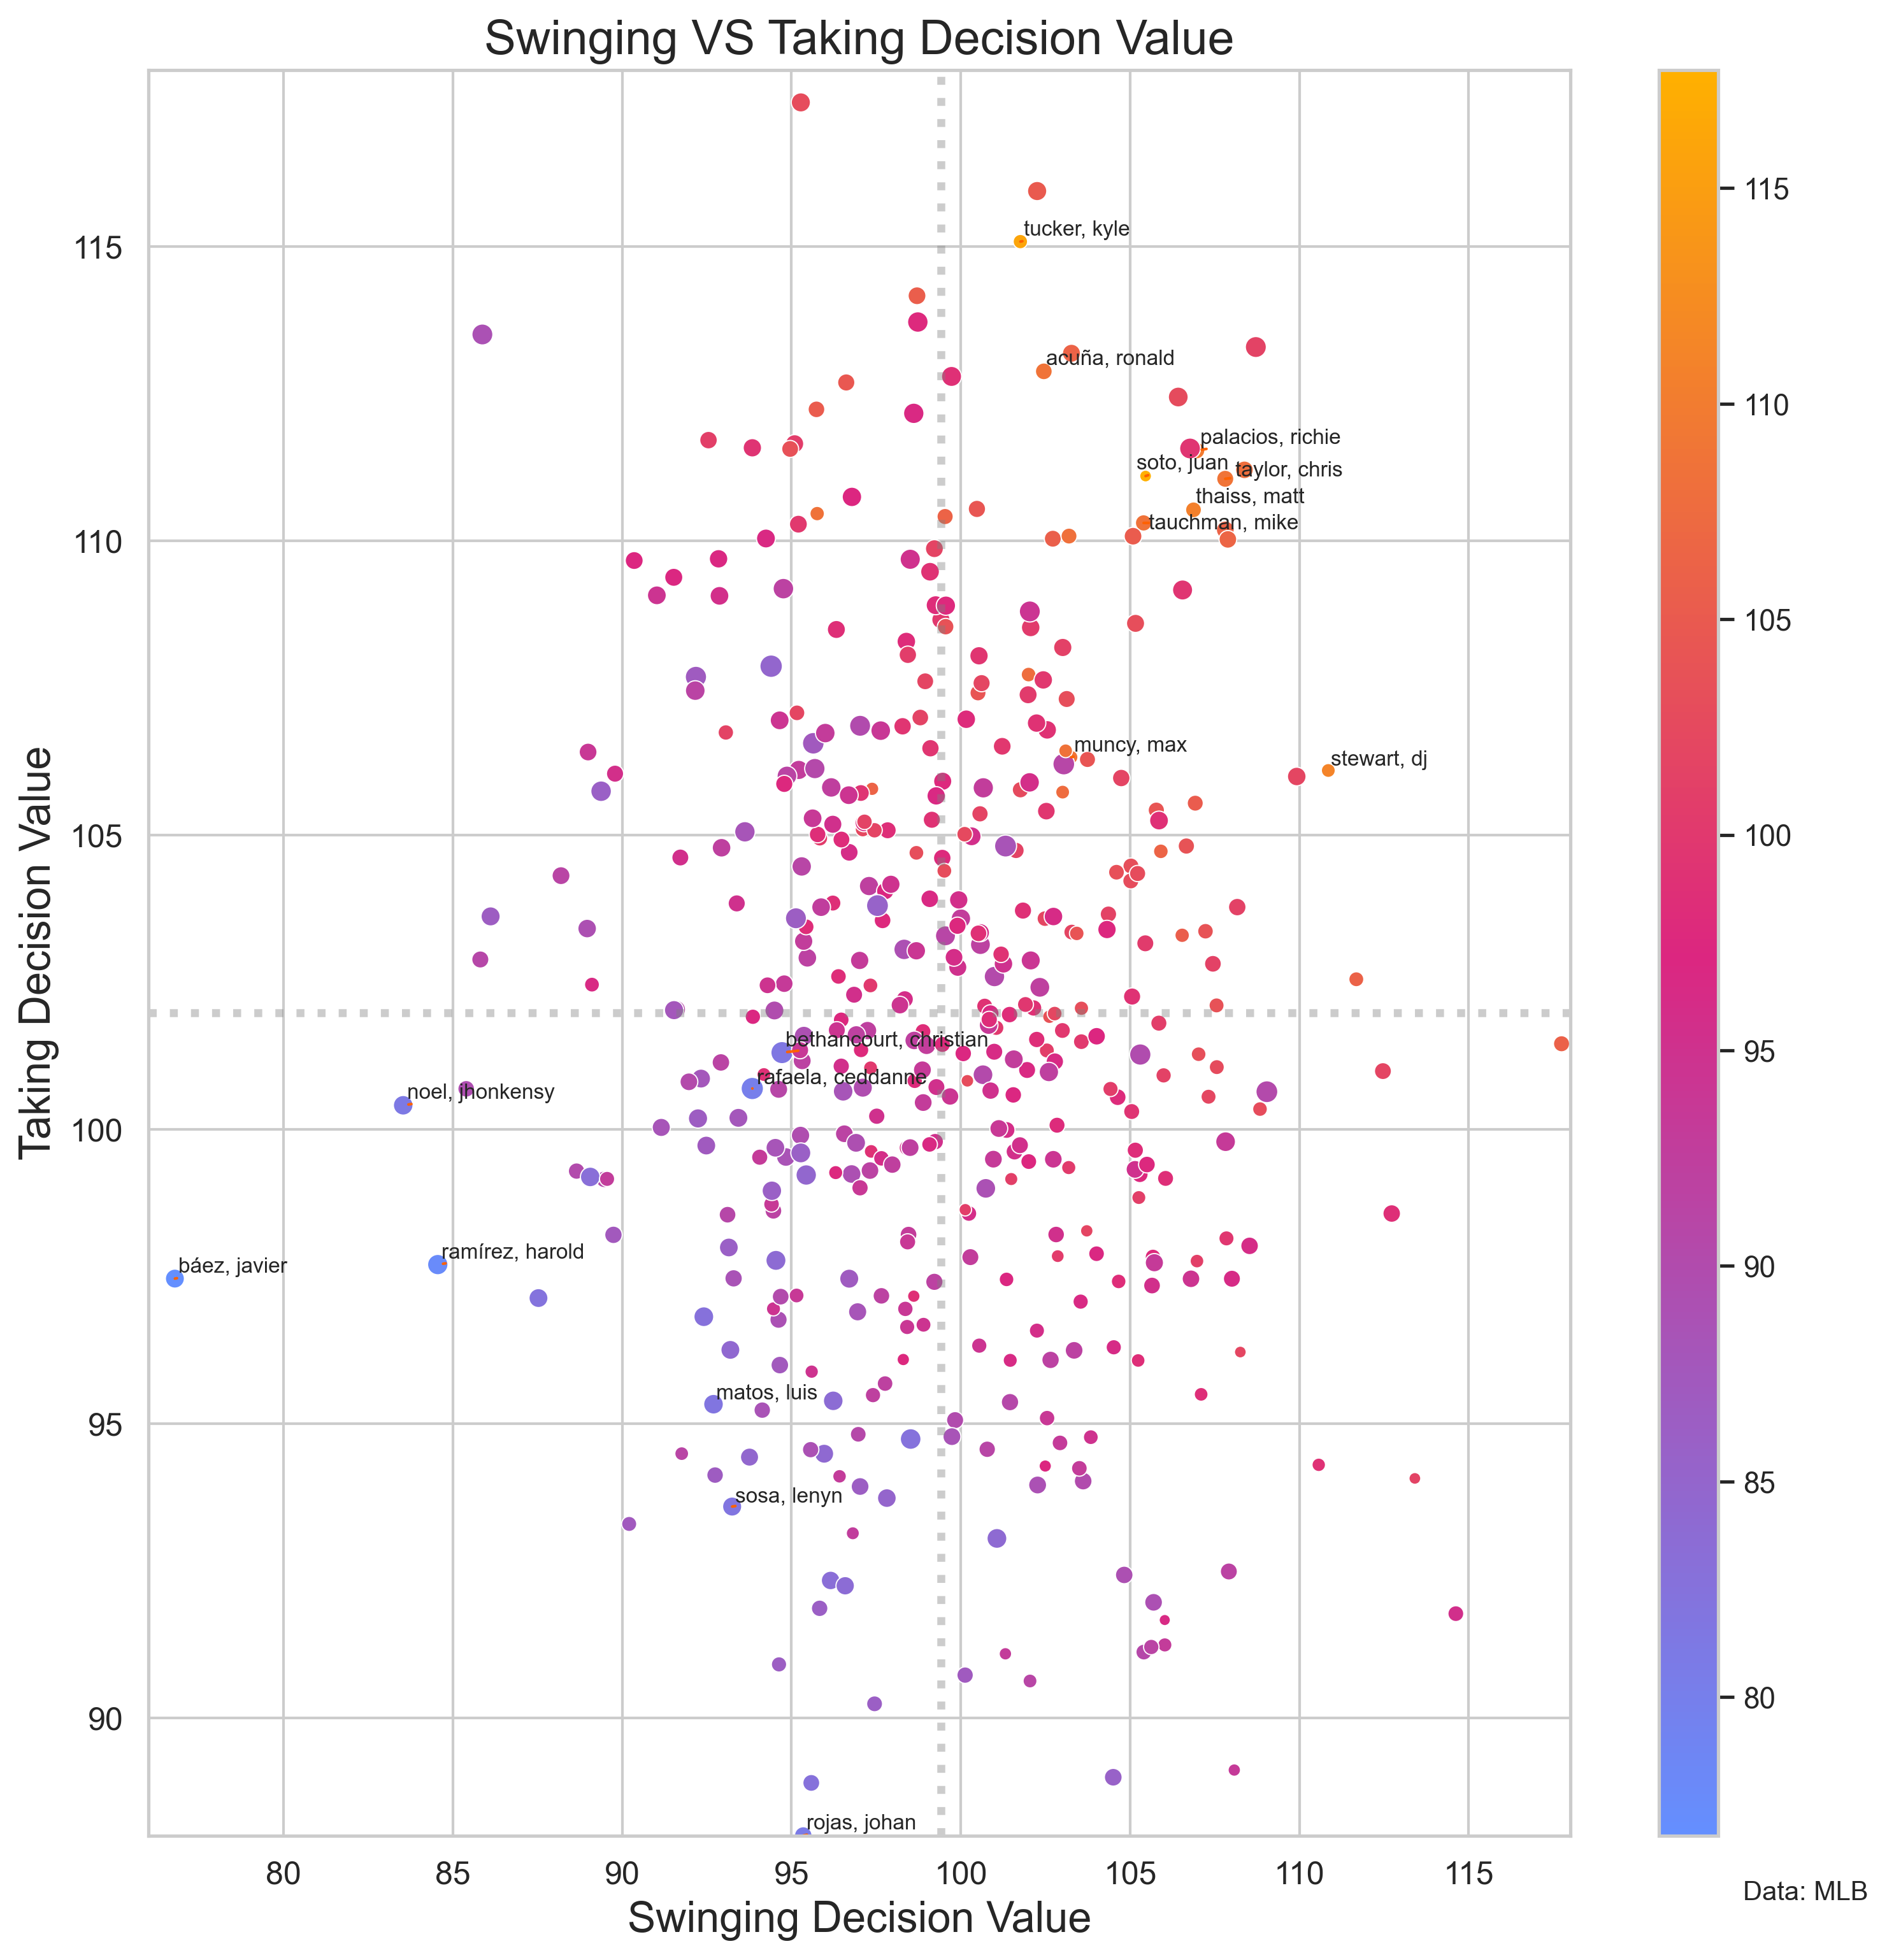

In [73]:
sns.set_theme(style = "whitegrid", palette = "pastel")
fig, ax = plt.subplots(1, 1, figsize = (12, 12), dpi = 300)

cmap_hue = matplotlib.colors.LinearSegmentedColormap.from_list("", [colour_palette[1], colour_palette[3], colour_palette[0]])
norm = plt.Normalize(min(all_data_2024_swing_plus_no_grouped['decision_value_swing'].min(), all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].min()), 
                     max(all_data_2024_swing_plus_no_grouped['decision_value_swing'].max(), all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].max()))

sns.scatterplot(x = all_data_2024_swing_plus_no_grouped['decision_value_swing'],
                y = all_data_2024_swing_plus_no_grouped['decision_value_no_swing'],
                hue = all_data_2024_swing_plus_no_grouped['decision_value_overall'],
                size = all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing']),
                palette = cmap_hue)

sm = plt.cm.ScalarMappable(cmap = cmap_hue, norm = norm)
cbar = ax.figure.colorbar(sm, ax = ax, orientation = 'vertical', aspect = 30)

ax.hlines(xmin = (math.floor((all_data_2024_swing_plus_no_grouped['decision_value_swing'].min()))),
            xmax = (math.ceil((all_data_2024_swing_plus_no_grouped['decision_value_swing'].max()))),
            y = all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].mean(), color = 'gray', linewidth = 3, linestyle = 'dotted', alpha = 0.4)

ax.vlines(ymin=(math.floor((all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].min()))),
            ymax= (math.ceil((all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].max()))),
            x = all_data_2024_swing_plus_no_grouped['decision_value_swing'].mean(), color = 'gray', linewidth = 3, linestyle = 'dotted', alpha = 0.4)



ax.set_xlim((math.floor((all_data_2024_swing_plus_no_grouped['decision_value_swing'].min()))),
            (math.ceil((all_data_2024_swing_plus_no_grouped['decision_value_swing'].max()))))


ax.set_ylim((math.floor((all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].min()))),
            (math.ceil((all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].max()))))
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)

ax.set_xlabel('Swinging Decision Value', fontsize = 16)
ax.set_ylabel('Taking Decision Value', fontsize = 16)
ax.get_legend().remove()

ax.set_title('Swinging VS Taking Decision Value', fontsize = 18)

ts = []


thresh = 115.5
thresh_2 = 87
for i in range(len(all_data_2024_swing_plus_no_grouped)):
   if (all_data_2024_swing_plus_no_grouped['decision_value_overall'].values[i] >= thresh) or (all_data_2024_swing_plus_no_grouped['decision_value_overall'].values[i] <= thresh_2):
      ts.append(ax.text(x = all_data_2024_swing_plus_no_grouped['decision_value_swing'].values[i],
      y = all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].values[i],
      s = all_data_2024_swing_plus_no_grouped['batter_name_swing'].values[i],
      fontsize = 8))


adjust_text(ts, arrowprops = dict(arrowstyle = "-", color = colour_palette[4], lw = 1), ax = ax)

# ax.text(x = -3.5, y = 3.71, s = f'Min. {min_pitches} Pitches', fontsize = 10, fontstyle = 'oblique', va = 'bottom',
#         bbox = dict(facecolor = 'white', edgecolor = 'black'))
# ax.text(x = -3.5, y = 3.31, s = f'Point Size Represents Swing%', fontsize = 10, fontstyle = 'oblique', va = 'bottom',
#         bbox = dict(facecolor = 'white', edgecolor = 'black'))

fig.text(0.875, 0.085, "Data: MLB", ha = 'right', va = 'center', fontsize = 10)

Text(0.875, 0.085, 'Data: MLB')

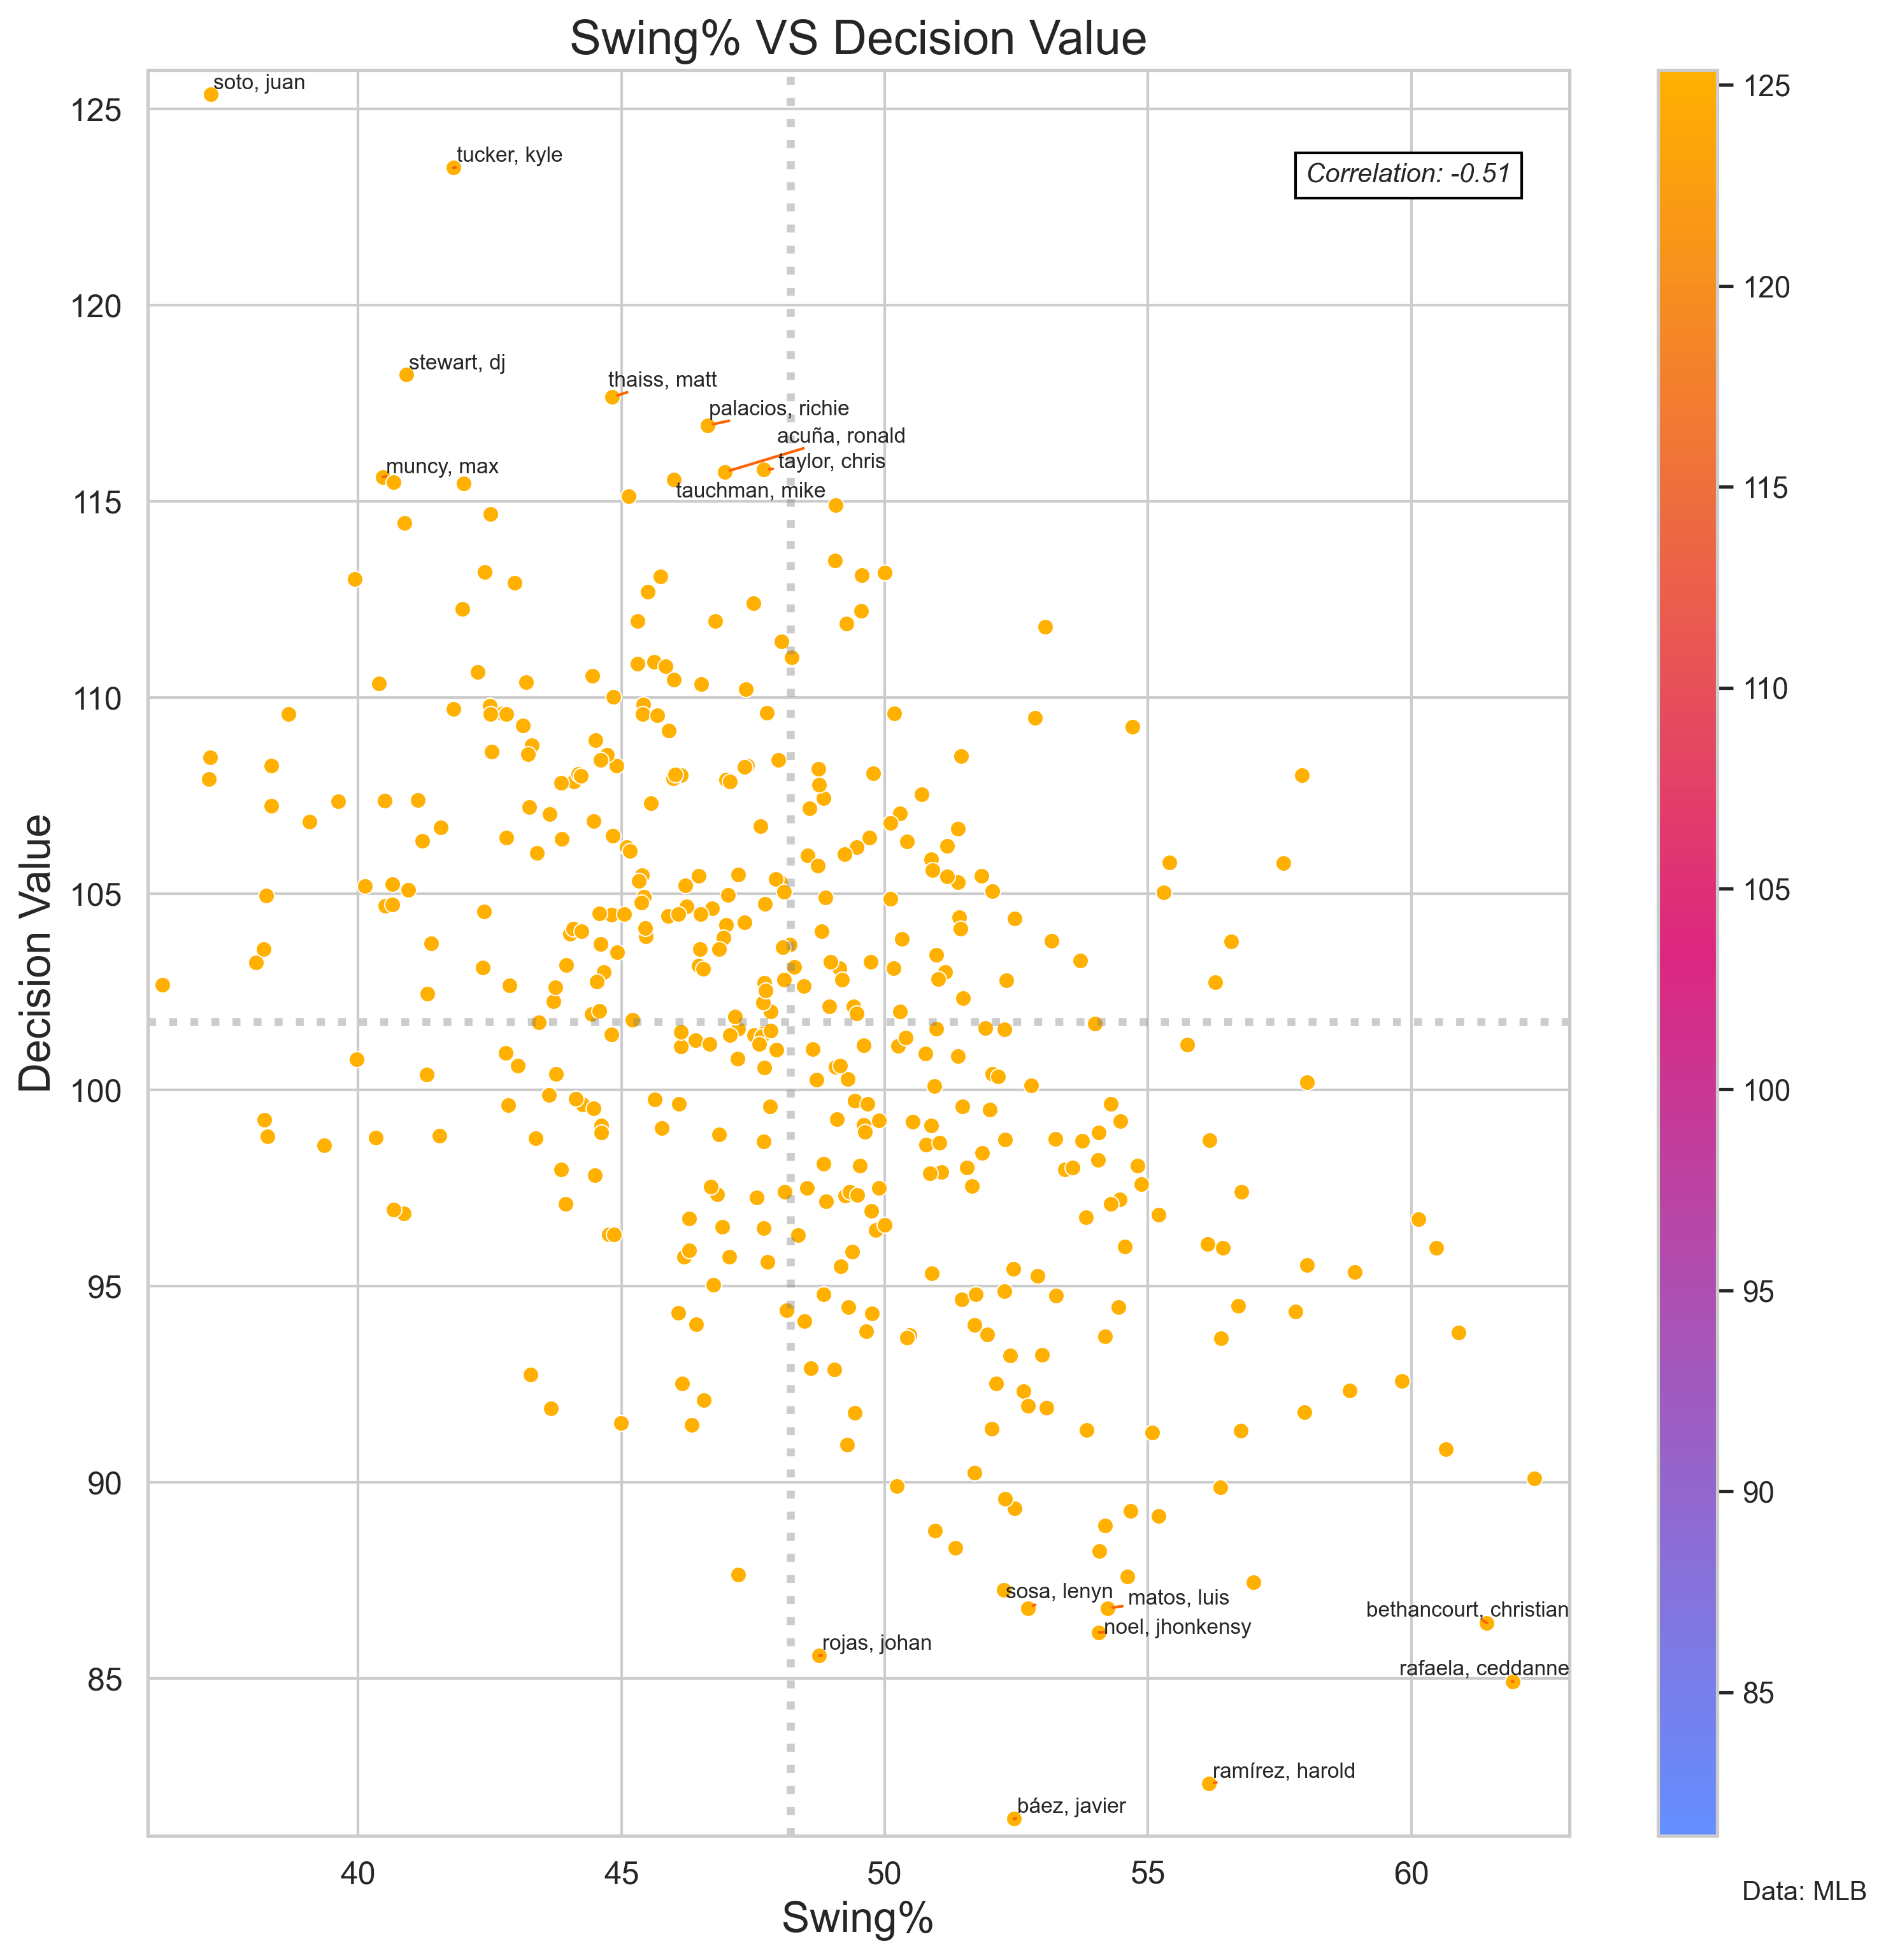

In [74]:
sns.set_theme(style = "whitegrid", palette = "pastel")
fig, ax = plt.subplots(1, 1, figsize = (12, 12), dpi = 300)

cmap_hue = matplotlib.colors.LinearSegmentedColormap.from_list("", [colour_palette[1], colour_palette[3], colour_palette[0]])
norm = plt.Normalize(all_data_2024_swing_plus_no_grouped['decision_value_overall'].min(), all_data_2024_swing_plus_no_grouped['decision_value_overall'].max())

sns.scatterplot(x = all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing']) * 100,
                y = all_data_2024_swing_plus_no_grouped['decision_value_overall'], color = colour_palette[0])

sm = plt.cm.ScalarMappable(cmap = cmap_hue, norm = norm)
cbar  = ax.figure.colorbar(sm, ax = ax, orientation = 'vertical', aspect = 30)

ax.hlines(xmin = (math.floor((all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'])).min() * 100)),
            xmax = (math.ceil((all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'])).max() * 100)),
            y = all_data_2024_swing_plus_no_grouped['decision_value_overall'].mean(), color = 'gray', linewidth = 3, linestyle = 'dotted', alpha = 0.4)

ax.vlines(ymin = (math.floor(all_data_2024_swing_plus_no_grouped['decision_value_overall'].min())),
            ymax = (math.ceil(all_data_2024_swing_plus_no_grouped['decision_value_overall'].max())),
            x = (all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'])).mean() * 100, color = 'gray', linewidth = 3, linestyle = 'dotted', alpha = 0.4)

ax.set_xlim((math.floor((all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'])).min() * 100)),
            (math.ceil((all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'])).max() * 100)))

ax.set_ylim((math.floor(all_data_2024_swing_plus_no_grouped['decision_value_overall'].min())),
            (math.ceil(all_data_2024_swing_plus_no_grouped['decision_value_overall'].max())))
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)

ax.set_xlabel('Swing%', fontsize = 16)
ax.set_ylabel('Decision Value', fontsize = 16)

ax.set_title('Swing% VS Decision Value', fontsize = 18)

ts = []

thresh = 115.5
thresh_2 = 87
for i in range(len(all_data_2024_swing_plus_no_grouped)):
   if (all_data_2024_swing_plus_no_grouped['decision_value_overall'].values[i] >= thresh) or (all_data_2024_swing_plus_no_grouped['decision_value_overall'].values[i] <= thresh_2):
      ts.append(ax.text(x = all_data_2024_swing_plus_no_grouped['pitches_swing'].values[i] / (all_data_2024_swing_plus_no_grouped['pitches_swing'].values[i] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'].values[i]) * 100,
      y = all_data_2024_swing_plus_no_grouped['decision_value_overall'].values[i],
      s = all_data_2024_swing_plus_no_grouped['batter_name_swing'].values[i],
      fontsize = 8))

corr_value = np.corrcoef(((all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'])) * 100, all_data_2024_swing_plus_no_grouped['decision_value_overall']))[0][1]
ax.text(x = 58, y = 123, s = f'Correlation: {corr_value:.2f}',fontsize = 10, fontstyle = 'oblique', va = 'bottom',
        bbox = dict(facecolor = 'white', edgecolor = 'black'))

adjust_text(ts, arrowprops = dict(arrowstyle = "-", color = colour_palette[4], lw = 1), ax = ax)

# ax.text(x = -3.5, y = 3.71, s = f'Min. {min_pitches} Pitches', fontsize = 10, fontstyle = 'oblique', va = 'bottom',
#         bbox = dict(facecolor = 'white', edgecolor = 'black'))
# ax.text(x = -3.5, y = 3.31, s = f'Point Size Represents Swing%', fontsize = 10, fontstyle = 'oblique', va = 'bottom',
#         bbox = dict(facecolor = 'white', edgecolor = 'black'))

fig.text(0.875, 0.085, "Data: MLB", ha = 'right', va = 'center', fontsize = 10)

##### The correlation between Swing% and Decision Value is -0.51, indicating a moderately strong inverse relationship between Swing% and Decision Value.